<center><h1>Speed dating project</h1></center>

There are some people who haven't found their second half due to different reasons. It doesn't matter why. What really matters is how to do so, of course if someone wants to. In this context, one of useful "tools" is speed dating. 
<br> Our events team tries to help a lonely person to find a partner by organising speed dating events. After a recent speed dating event, our events team received complaints from customers that they had to spend too much time talking to people who were clearly never going to be a match for them. Therefore they are interested in whether they could predict ahead of time the most likely matches. If they could be over 70% confident that someone is a match, they would match them at the start of the event. They would like to know, based on this criteria, what proportion of attendees might be correctly pre-matched.
<br>This notebook is an attempt to derive useful insights and to see which characteristics/features drive the decision making process. The data can be downloaded from [here](https://github.com/datacamp/careerhub-data/tree/master/Speed%20Dating).
<br> List of variables and their meaning:


Feature|Meaning
-------|-------
gender| Gender of self
age| Age of self
age_o| Age of partner
d_age| Difference in age
race| Race of self
race_o| Race of partner
samerace| Whether the two persons have the same race or not.
importance_same_race| How important is it that partner is of same race?
importance_same_religion| How important is it that partner has same religion?
field| Field of study
pref_o_attractive| How important does partner rate attractiveness
pref_o_sinsere| How important does partner rate sincerity
pref_o_intelligence| How important does partner rate intelligence
pref_o_funny| How important does partner rate being funny
pref_o_ambitious| How important does partner rate ambition
pref_o_shared_interests| How important does partner rate having shared interests
attractive_o| Rating by partner (about me) at night of event on attractiveness
sincere_o| Rating by partner (about me) at night of event on sincerity
intelligence_o| Rating by partner (about me) at night of event on intelligence
funny_o| Rating by partner (about me) at night of event on being funny
ambitous_o| Rating by partner (about me) at night of event on being ambitious
shared_interests_o| Rating by partner (about me) at night of event on shared interest
attractive_important| What do you look for in a partner - attractiveness
sincere_important| What do you look for in a partner - sincerity
intellicence_important| What do you look for in a partner - intelligence
funny_important| What do you look for in a partner - being funny
ambtition_important| What do you look for in a partner - ambition
shared_interests_important| What do you look for in a partner - shared interests
attractive| Rate yourself - attractiveness
sincere| Rate yourself - sincerity
intelligence| Rate yourself - intelligence
funny| Rate yourself - being funny
ambition| Rate yourself - ambition
attractive_partner| Rate your partner - attractiveness
sincere_partner| Rate your partner - sincerity
intelligence_partner| Rate your partner - intelligence
funny_partner| Rate your partner - being funny
ambition_partner| Rate your partner - ambition
shared_interests_partner| Rate your partner - shared interests
sports| Your own interests [1-10]
tvsports| Your own interests [1-10]
exercise| Your own interests [1-10]
dining| Your own interests [1-10]
museums| Your own interests [1-10]
art| Your own interests [1-10]
hiking| Your own interests [1-10]
gaming| Your own interests [1-10]
clubbing| Your own interests [1-10]
reading| Your own interests [1-10]
tv| Your own interests [1-10]
theater| Your own interests [1-10]
movies| Your own interests [1-10]
concerts| Your own interests [1-10]
music| Your own interests [1-10]
shopping| Your own interests [1-10]
yoga| Your own interests [1-10]
interests_correlate| Correlation between participant’s and partner’s ratings of interests.
expected_happy_with_sd_people| How happy do you expect to be with the people you meet during the speed-dating event?
expected_num_interested_in_me| Out of the 20 people you will meet, how many do you expect will be interested in dating you?
expected_num_matches| How many matches do you expect to get?
like| Did you like your partner?
guess_prob_liked| How likely do you think it is that your partner likes you?
met| Have you met your partner before?
decision| Decision at night of event.
decision_o| Decision of partner at night of event.
match| Match (yes/no)

## Table of Contents


---


* [Importing some packages](#Part0) 

* [Loading the data](#Part1) 

* [Exploratory data analysis (EDA)](#Part2)

* [Feature engineering](#Part3)

* [Model estimation](#Part4)

## Importing some packages <a name="Part0"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from scipy import stats
from functools import partial
from scipy.optimize import fmin
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state, column_or_1d
from sklearn.utils.multiclass import type_of_target
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

## Loading the data <a name="Part1"></a>

In [ ]:
data = pd.read_csv('speed_dating.csv')
data.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,35,20,20,20,0,5,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6,8,8,8,8,6,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.14,[0-0.33],3,2,4,[0-4],[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,60,0,0,40,0,0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7,8,10,7,7,5,[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.54,[0.33-1],3,2,4,[0-4],[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,2,4,[2-5],[2-5],Law,19,18,19,18,14,12,[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],10,10,10,10,10,10,[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.16,[0-0.33],3,2,4,[0-4],[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,30,5,15,40,5,5,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7,8,9,8,9,8,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.61,[0.33-1],3,2,4,[0-4],[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,2,4,[2-5],[2-5],Law,30,10,20,10,10,20,[21-100],[0-15],[16-20],[0-15],[0-15],[16-20],8,7,9,6,9,7,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.21,[0-0.33],3,2,4,[0-4],[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1


In [ ]:
data.tail()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
8373,1,21,male,25,26,1,[0-1],European/Caucasian-American,'Latino/Hispanic American',0,1,1,[0-1],[0-1],'Climate Dynamics',10,10,30,20,10,15,[0-15],[0-15],[21-100],[16-20],[0-15],[0-15],10,5,3,2,6,5,[9-10],[0-5],[0-5],[0-5],[6-8],[0-5],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],0.64,[0.33-1],10,?,3,[7-10],[0-3],[3-5],2,5,[0-5],[5-6],0,0,1,0
8374,1,21,male,25,24,1,[0-1],European/Caucasian-American,Other,0,1,1,[0-1],[0-1],'Climate Dynamics',50,20,10,5,10,5,[21-100],[16-20],[0-15],[0-15],[0-15],[0-15],6,3,7,3,7,2,[6-8],[0-5],[6-8],[0-5],[6-8],[0-5],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],0.71,[0.33-1],10,?,3,[7-10],[0-3],[3-5],4,4,[0-5],[0-4],0,0,0,0
8375,1,21,male,25,29,4,[4-6],European/Caucasian-American,'Latino/Hispanic American',0,1,1,[0-1],[0-1],'Climate Dynamics',40,10,30,10,10,?,[21-100],[0-15],[21-100],[0-15],[0-15],[0-15],2,1,2,2,2,1,[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],-0.46,[-1-0],10,?,3,[7-10],[0-3],[3-5],6,5,[6-8],[5-6],0,0,0,0
8376,1,21,male,25,22,3,[2-3],European/Caucasian-American,'Asian/Pacific Islander/Asian-American',0,1,1,[0-1],[0-1],'Climate Dynamics',10,25,25,10,10,20,[0-15],[21-100],[21-100],[0-15],[0-15],[16-20],5,7,5,5,3,6,[0-5],[6-8],[0-5],[0-5],[0-5],[6-8],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],0.62,[0.33-1],10,?,3,[7-10],[0-3],[3-5],5,5,[0-5],[5-6],0,0,1,0
8377,1,21,male,25,22,3,[2-3],European/Caucasian-American,'Asian/Pacific Islander/Asian-American',0,1,1,[0-1],[0-1],'Climate Dynamics',20,20,10,15,5,30,[16-20],[16-20],[0-15],[0-15],[0-15],[21-100],8,8,7,7,7,7,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],0.01,[0-0.33],10,?,3,[7-10],[0-3],[3-5],4,5,[0-5],[5-6],0,0,1,0


As there are some redundant columns that aren't described in the list of variables, let's first get rid of them. Besides there some unnecessary quote signs (') in race, race_o, and field columns. Let's deal with this issue too.

In [ ]:
redundant_cols = [col for col in data.columns if col.startswith('d_')]
redundant_cols.remove('d_age')
redundant_cols.extend(['has_null', 'wave'])
data = data[[col for col in data.columns if col not in redundant_cols]]
data['race'] = data['race'].apply(lambda x: x.replace("'", ''))
data['race_o'] = data['race_o'].apply(lambda x: x.replace("'", ''))
data['field'] = data['field'].apply(lambda x: x.replace("'", ''))
data.head()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match
0,female,21,27,6,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2,4,Law,35,20,20,20,0,5,6,8,8,8,8,6,15,20,20,15,15,15,6,8,8,8,7,6,9,7,7,6,5,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,0.14,3,2,4,7,6,0,1,0,0
1,female,21,22,1,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2,4,Law,60,0,0,40,0,0,7,8,10,7,7,5,15,20,20,15,15,15,6,8,8,8,7,7,8,7,8,5,6,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,0.54,3,2,4,7,5,1,1,0,0
2,female,21,22,1,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2,4,Law,19,18,19,18,14,12,10,10,10,10,10,10,15,20,20,15,15,15,6,8,8,8,7,5,8,9,8,5,7,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,0.16,3,2,4,7,?,1,1,1,1
3,female,21,23,2,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2,4,Law,30,5,15,40,5,5,7,8,9,8,9,8,15,20,20,15,15,15,6,8,8,8,7,7,6,8,7,6,8,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,0.61,3,2,4,7,6,0,1,1,1
4,female,21,24,3,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2,4,Law,30,10,20,10,10,20,8,7,9,6,9,7,15,20,20,15,15,15,6,8,8,8,7,5,6,7,7,6,6,9,2,8,9,1,1,5,1,5,6,9,1,10,10,9,8,1,0.21,3,2,4,6,6,0,1,1,1


In [ ]:
data.tail()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match
8373,male,25,26,1,European/Caucasian-American,Latino/Hispanic American,0,1,1,Climate Dynamics,10,10,30,20,10,15,10,5,3,2,6,5,70,0,15,15,0,0,8,7,6,7,7,3,5,5,5,?,?,8,2,5,10,10,10,7,1,9,8,3,7,9,10,10,7,3,0.64,10,?,3,2,5,0,0,1,0
8374,male,25,24,1,European/Caucasian-American,Other,0,1,1,Climate Dynamics,50,20,10,5,10,5,6,3,7,3,7,2,70,0,15,15,0,0,8,7,6,7,7,4,6,8,4,4,?,8,2,5,10,10,10,7,1,9,8,3,7,9,10,10,7,3,0.71,10,?,3,4,4,0,0,0,0
8375,male,25,29,4,European/Caucasian-American,Latino/Hispanic American,0,1,1,Climate Dynamics,40,10,30,10,10,?,2,1,2,2,2,1,70,0,15,15,0,0,8,7,6,7,7,4,7,8,8,8,?,8,2,5,10,10,10,7,1,9,8,3,7,9,10,10,7,3,-0.46,10,?,3,6,5,0,0,0,0
8376,male,25,22,3,European/Caucasian-American,Asian/Pacific Islander/Asian-American,0,1,1,Climate Dynamics,10,25,25,10,10,20,5,7,5,5,3,6,70,0,15,15,0,0,8,7,6,7,7,4,6,5,4,?,5,8,2,5,10,10,10,7,1,9,8,3,7,9,10,10,7,3,0.62,10,?,3,5,5,0,0,1,0
8377,male,25,22,3,European/Caucasian-American,Asian/Pacific Islander/Asian-American,0,1,1,Climate Dynamics,20,20,10,15,5,30,8,8,7,7,7,7,70,0,15,15,0,0,8,7,6,7,7,3,7,6,4,8,1,8,2,5,10,10,10,7,1,9,8,3,7,9,10,10,7,3,0.01,10,?,3,4,5,0,0,1,0


There are some misspelled column names. Let's rename them.

In [ ]:
data.rename(columns={'intellicence_important': 'intelligence_important',
                     'ambtition_important': 'ambition_important',
                     'ambitous_o': 'ambitious_o'}, 
            inplace=True)

## Exploratory data analysis (EDA) <a name="Part2"></a>

Let's start with getting general info (presence of missing values, data types, number of columns and rows) on the data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   gender                         8378 non-null   object
 1   age                            8378 non-null   object
 2   age_o                          8378 non-null   object
 3   d_age                          8378 non-null   int64 
 4   race                           8378 non-null   object
 5   race_o                         8378 non-null   object
 6   samerace                       8378 non-null   int64 
 7   importance_same_race           8378 non-null   object
 8   importance_same_religion       8378 non-null   object
 9   field                          8378 non-null   object
 10  pref_o_attractive              8378 non-null   object
 11  pref_o_sincere                 8378 non-null   object
 12  pref_o_intelligence            8378 non-null   object
 13  pre

So, the data contains 8378 entries(observations) and 66 columns. Moreover there is no missing values, which is already good. But it turns out that some features contain '?'. Let's find out how many of them do.

In [ ]:
columns_with_na = [col for col in data.columns 
                   if '?' in data[col].unique().tolist()]
print(f'{len(columns_with_na)} features contain missing values.')

columns_with_no_na = [col for col in data.columns 
                      if col not in columns_with_na]
print(f"\nThe following columns do not contain missing values: \n{', '.join(columns_with_no_na)}")

60 features contain missing values.

The following columns do not contain missing values: 
gender, d_age, samerace, decision, decision_o, match


Next let's create a feature to identify each client by combining gender, age, race, field, and characteristics' importance variables.

In [ ]:
for col in ['gender', 'age', 'race', 'field', 'attractive_important', 
            'sincere_important', 'intelligence_important', 'funny_important',
            'ambition_important', 'shared_interests_important']:
    if 'id' not in data.columns:
        data['id'] = data[col].astype(str)
    else:
        data['id'] = data['id'] + data[col].astype(str)
unique_id_list = list(data['id'].unique())
id_map_dic = {unique_id_list[i]: i for i in range(len(unique_id_list))}
data['id'] = data['id'].map(id_map_dic)

unique_id_list = list(data['id'].unique())
female_num  = np.sum([1 if data[data['id']==i].iloc[0]['gender']=='female' 
                      else 0 for i in unique_id_list])
print(f"There are {female_num} female and {data['id'].nunique() - female_num} male clients.")

There are 271 female and 276 male clients.


As there are only 8378 observations, it's clear that a person managed to talk to only some of possible partners. Therefore it's really important to try to model decision making process to help our clients.

In [ ]:
# data.drop('id2', axis=1, inplace=True)

It'll be good to identify a partner's gender. As we don't have info on the partner's field and gender, let's use only age, race, and characteristics' importance variables to construct identification variable.

In [ ]:
for col in ['age', 'race', 'attractive_important', 'sincere_important', 
            'intelligence_important', 'funny_important',
            'ambition_important', 'shared_interests_important']:
    if 'id2' not in data.columns:
        data['id2'] = data[col].astype(str)
    else:
        data['id2'] = data['id2'] + data[col].astype(str)
unique_id2_list = list(data['id2'].unique())
id2_map_dic = {unique_id2_list[i]: i for i in range(len(unique_id2_list))}
data['id2'] = data['id2'].map(id2_map_dic)

unique_id2_list = list(data['id2'].unique())
female_num  = np.sum([1 if data[data['id2']==i].iloc[0]['gender']=='female' 
                      else 0 for i in unique_id2_list])
print(f"There are {female_num} female and {data['id2'].nunique() - female_num} male clients.")

There are 271 female and 272 male clients.


Judging by the male client numbers obtained, we notice that the second type of identification has some errors: some clients have been merged into one id because of identical features (they can be distinguished if we consider gender and field features). Therefore let's find out that clients and delete them if we don't lose too much info.

In [ ]:
unique_id_list = list(data['id2'].unique())
id_check_dic = {i: list(data[data['id2']==i]['id'].unique()) 
                for i in unique_id_list}
remove_list = [i for i in id_check_dic if len(id_check_dic[i]) > 1]
print(f"We'll lose {data[data['id2'].isin(remove_list)].shape[0]} observations if we remove the aforementioned clients.")

We'll lose 149 observations if we remove the aforementioned clients.


Let's remove these observations.

In [ ]:
data = data[~data['id2'].isin(remove_list)]
data.reset_index(drop=True, inplace=True)
data.shape

(8229, 68)

In [ ]:
unique_id2_list = list(data['id2'].unique())
female_num  = np.sum([1 if data[data['id2']==i].iloc[0]['gender']=='female' 
                      else 0 for i in unique_id2_list])
print(f"There are {female_num} female and {data['id2'].nunique() - female_num} male clients.")

There are 268 female and 271 male clients.


In [ ]:
for col in ['age_o', 'race_o', 'pref_o_attractive', 
            'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
            'pref_o_ambitious', 'pref_o_shared_interests']:
    if 'id_partner' not in data.columns:
        data['id_partner'] = data[col].astype(str)
    else:
        data['id_partner'] = data['id_partner'] + data[col].astype(str)
data['id_partner'] = data['id_partner'].map(id2_map_dic)

In [ ]:
print(f"We'll lose {data[(data['id_partner'].isnull()) | (data['id_partner'].isin(remove_list))].shape[0]} observations if we remove the aforementioned clients and clients without gender or field info from the partners' list.")

We'll lose 159 observations if we remove the aforementioned clients and clients without gender or field info from the partners' list.


Let's remove these observations.

In [ ]:
data = data[(~data['id_partner'].isnull()) & 
            (~data['id_partner'].isin(remove_list))]
data.reset_index(drop=True, inplace=True)
data.drop('id', axis=1, inplace=True)
data.rename(columns={'id2': 'id'}, inplace=True)
data.shape

(8070, 68)

In [ ]:
unique_id_partner_list = list(data['id_partner'].unique())
female_num  = np.sum([1 if data[data['id']==i].iloc[0]['gender']=='female' 
                      else 0 for i in unique_id_partner_list])
print(f"There are {female_num} female and {data['id_partner'].nunique() - female_num} male clients.")

There are 268 female and 271 male clients.


In [ ]:
unique_id_list = list(data['id_partner'].unique())
gender_map_dic = {i: data[data['id']==i].iloc[0]['gender'] 
                  for i in unique_id_list}
data['gender_partner'] = data['id_partner'].map(gender_map_dic)
print(f"{(data['gender'] == data['gender_partner']).sum()} pairs out of 8070 have the same gender.")

0 pairs out of 8070 have the same gender.


Let's create a dictionary for mapping self rated characteristics (rated by a partner) for a partner.

In [ ]:
self_rated_char_list = ['attractive', 'sincere', 'intelligence', 
                        'funny', 'ambition']
self_rated_char_dic = {col: {i: data[data['id']==i].iloc[0][col] 
                             for i in data['id'].unique()} 
                       for col in self_rated_char_list}

Now we can add the columns of self rated characteristics (rated by a partner) for a partner to the data set.

In [ ]:
for col in self_rated_char_list:
    data['psrated_'+col] = data['id'].map(self_rated_char_dic[col])

From this point it is worth to devide the data into training and testing sets. But let's first check the distribution of target variable (decision column).

In [ ]:
data['decision'].value_counts(normalize=True)

0    0.580669
1    0.419331
Name: decision, dtype: float64

Though difference between the numbers of negative and positive decisions is not too big, let's use stratified train-test-split. We also need to make sure that the same client is not present in both train and test sets. Therefore we need to use StratifiedGroupKFold which is coded [here](https://www.kaggle.com/realsid/stratifiedgroupkfold-using-sklearn). So let's import StratifiedGroupKFold class from the source and devide data into folds. Then we'll split data into train and test sets.

In [ ]:
class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        n_classes = len(y_cnt)
        
        
        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True)
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(-np.std(y_counts_per_group, axis=1),
                                       kind='mergesort')

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold, y_cnt=y_cnt,
                group_y_counts=group_y_counts)
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group_idx in enumerate(groups_inv)
                            if group_idx in groups_per_fold[i]]
            yield test_indices

    def _find_best_fold(
            self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(
                y_counts_per_fold / y_cnt.reshape(1, -1),
                axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval or
                np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold

In [ ]:
X = data[[col for col in data.columns 
          if col not in ['decision', 'decision_o', 
                         'match', 'id', 'id_partner', 
                         'gender_partner']]]
y = data['decision']

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42)
index_fold_dic = {}
for fold_ind, (dev_ind, val_ind) in enumerate(sgkf.split(X, y, groups=data['id'])):
    index_fold_dic[fold_ind] = (dev_ind, val_ind)

In [ ]:
np.random.seed(42)
random_fold = np.random.randint(5)

X_train = X.iloc[index_fold_dic[random_fold][0]]
y_train = y.iloc[index_fold_dic[random_fold][0]]
X_test = X.iloc[index_fold_dic[random_fold][1]]
y_test = y.iloc[index_fold_dic[random_fold][1]]

#train_index_list = list(X_train.index)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

train_data = pd.concat([X_train, y_train], axis=1, sort=False)

In [ ]:
# [i for i in data.columns if i.startswith('pref_o')]
# [i for i in data.columns if i.endswith('_o') 
#  and i not in ['age_o', 'race_o', 'decision_o']]

In [ ]:
# X = data[[col for col in data.columns 
#           if col not in ['decision', 'decision_o', 'match']]]
# y = data['decision']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     stratify=y, random_state=9)
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

# train_data = pd.concat([X_train, y_train], axis=1, sort=False)

In [ ]:
y_train.value_counts(normalize=True)

0    0.580365
1    0.419635
Name: decision, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.581886
1    0.418114
Name: decision, dtype: float64

In [ ]:
# for i in index_fold_dic:
#   temp_dev = data.iloc[index_fold_dic[i][0]]['id'].to_list()
#   temp_val = data.iloc[index_fold_dic[i][1]]['id'].to_list()
#   temp_list = [1 for j in temp_val if j in temp_dev]
#   print(np.sum(temp_list))

Next let's find out how many missing values there are for each feature in train and test data.

In [ ]:
train_na_count_dic = {}
train_na_count_dic['features'] = [col for col in X_train.columns]
train_na_count_dic['missing values'] = [X_train[X_train[col]=='?'].shape[0] 
                                        for col in X_train.columns]
train_na_count_dic['missing values (%)'] = [np.round(100*X_train[X_train[col]=='?'].shape[0]/\
                                                     X_train.shape[0], 2)
                                            for col in X_train.columns]
                                      
pd.DataFrame.from_dict(train_na_count_dic).\
             sort_values('missing values', ascending=False).\
             reset_index(drop=True)

,features,missing values,missing values (%)
0,expected_num_interested_in_me,5097,78.93
1,expected_num_matches,966,14.96
2,shared_interests_o,844,13.07
3,shared_interests_partner,778,12.05
4,ambitious_o,553,8.56
...,...,...,...
63,samerace,0,0.00
64,race_o,0,0.00
65,race,0,0.00
66,d_age,0,0.00


In [ ]:
test_na_count_dic = {}
test_na_count_dic['features'] = [col for col in X_test.columns]
test_na_count_dic['missing values'] = [X_test[X_test[col]=='?'].shape[0] 
                                        for col in X_test.columns]
test_na_count_dic['missing values (%)'] = [np.round(100*X_test[X_test[col]=='?'].shape[0]/\
                                                     X_test.shape[0], 2)
                                            for col in X_test.columns]
                                      
pd.DataFrame.from_dict(test_na_count_dic).\
             sort_values('missing values', ascending=False).\
             reset_index(drop=True)

,features,missing values,missing values (%)
0,expected_num_interested_in_me,1276,79.16
1,shared_interests_partner,261,16.19
2,shared_interests_o,195,12.10
3,expected_num_matches,185,11.48
4,ambition_partner,142,8.81
...,...,...,...
63,art,0,0.00
64,hiking,0,0.00
65,gaming,0,0.00
66,ambition_important,0,0.00


In [ ]:
# na_count_dic = {}
# na_count_dic['features'] = [col for col in columns_with_na]
# na_count_dic['missing values'] = [data[data[col]=='?'].shape[0] 
#                                   for col in columns_with_na]
# na_count_dic['missing values (%)'] = [np.round(100*data[data[col]=='?'].shape[0]/\
#                                                data.shape[0], 2)
#                                       for col in columns_with_na]
                                      
# pd.DataFrame.from_dict(na_count_dic).\
#              sort_values('missing values', ascending=False).\
#              reset_index(drop=True)

Around 79 % of expected_num_interested_in_me column is missing in train set. This can be a warning sign to exclude it from the analysis, but let's check how it goes with target variable (decision: whether to meet a partner or not after speed-dating night). <br>It seems, when expected_num_interested_in_me is greater than 13, the positive decision dominates (See chart below). Though there are exceptions in case of 7, 9, and 19, we can try to use the column as a feature for upcoming prediction task (whether a person will decide to meet a partner after speed-dating night or not).

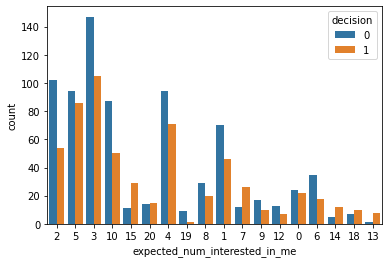

In [ ]:
sns.countplot(x='expected_num_interested_in_me', 
              data=train_data[train_data['expected_num_interested_in_me']!='?'], 
              hue='decision')
plt.show()

In [ ]:
temp_data = train_data[train_data['expected_num_interested_in_me']!='?'][['expected_num_interested_in_me', 
                                                                          'decision']]
temp_data['expected_num_interested_in_me'] = temp_data['expected_num_interested_in_me'].apply(float)
temp_data[temp_data['expected_num_interested_in_me']>13]['decision'].value_counts(normalize=True)

1    0.59292
0    0.40708
Name: decision, dtype: float64

### Univariate analysis

Let's start analysis with categorical variables. It will be helpful to look at how many unique values these features have.

In [ ]:
cat_col_list = ['gender', 'race', 'race_o', 'samerace', 'met', 'field']

for col in cat_col_list:
  print(f'{col} has {X_train[col].nunique()} unique values.')

gender has 2 unique values.
race has 5 unique values.
race_o has 5 unique values.
samerace has 2 unique values.
met has 8 unique values.
field has 215 unique values.


Let's check 260 unique values of field column.

In [ ]:
X_train['field'].unique()

array(['Law', 'law', 'Masters in Public Administration',
       'Masters of Social Work&Education', 'Finance', 'Business',
       'political science', 'Psychology', 'social work', 'Social Work',
       'Speech Language Pathology', 'Speech Languahe Pathology',
       'Applied Maths/Econs', 'Mathematics', 'Statistics',
       'Organizational Psychology', 'Operations Research',
       'Mechanical Engineering', 'Economics', 'Finanace',
       'Undergrad - GS', 'Mathematical Finance', 'Medicine', 'LAW',
       'psychology', 'German Literature', 'MBA', 'Engineering',
       'Classics', 'Operations Research [SEAS]', 'microbiology',
       'Masters of Social Work', 'Communications', 'Marketing',
       'Chemistry', 'International Educational Development',
       'Education Administration', 'Computer Science',
       'Climate-Earth and Environ. Science', 'financial math',
       'Business- MBA', 'chemistry', 'Religion', 'Film', 'Sociology',
       'Economics; English', 'Economics; Sociology', '

Probably converting field column into lower case will reduce the number of unique values.

In [ ]:
X_train['field'] = X_train['field'].apply(lambda x: x.lower())
print(f"field column has {X_train['field'].nunique()} unique values now.")

field column has 185 unique values now.


Let's apply the same transformation to test set.

In [ ]:
X_test['field'] = X_test['field'].apply(lambda x: x.lower())

Let's look at unique values of the other categorical variables too.

In [ ]:
for col in cat_col_list:
  if col == 'field':
    continue
  print(f'Unique values of {col} column are {X_train[col].unique()}.')

Unique values of gender column are ['female' 'male'].
Unique values of race column are ['Asian/Pacific Islander/Asian-American' 'European/Caucasian-American'
 'Other' 'Latino/Hispanic American' 'Black/African American'].
Unique values of race_o column are ['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Latino/Hispanic American' 'Other' 'Black/African American'].
Unique values of samerace column are [0 1].
Unique values of met column are ['0' '1' '?' '3' '5' '7' '8' '6'].


Let's use countplot for the categorical variables excluding field column.

Abbreviations:
APIAA: Asian/Pacific Islander/Asian-American
ECA: European/Caucasian-American
O: Other
LHA: Latino/Hispanic American
BAA: Black/African American


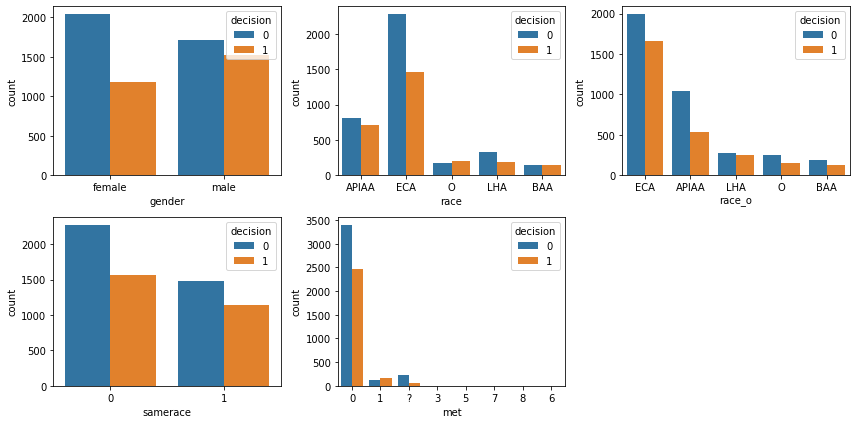

In [ ]:
fig = plt.figure(figsize=(12, 6))
for i in range(len(cat_col_list)-1):
  plt.subplot(2, 3, i+1)
  if cat_col_list[i] in ['race', 'race_o']:
    g = sns.countplot(x=cat_col_list[i], data=train_data, hue='decision')
    g.set_xticklabels([''.join(re.findall(r'[A-Z]', i.get_text())) 
                       if i.get_text()!='?' else 'Missing' 
                       for i in g.get_xticklabels()])
  else:
    sns.countplot(x=cat_col_list[i], data=train_data, hue='decision')
plt.tight_layout()

print('Abbreviations:')
print('\n'.join([f"{''.join(re.findall(r'[A-Z]', i))}: {i}" 
                 if i!='?' else 'Missing: ?' 
                 for i in train_data['race'].unique()]))

Here are hypothesis from the plots above:
1. females are more prone to negative decision
2. European/Caucasian-American are more prone to negative decision
3. negative decision is more probable if the partner is Asian/Pacific Islander/Asian-American
4. negative decision is more probable if races are different
5. negative decision is more probable if partners haven't met before

The analysis for field column will be conducted differently.

In [ ]:
train_data['field'] = train_data['field'].apply(lambda x: x.lower())
field_grouped_data = train_data.groupby('field')['decision'].agg(['count', 'sum'])
field_grouped_data.columns = ['count', 'positive decision']
field_grouped_data['negative decision'] = field_grouped_data['count'] - \
                                          field_grouped_data['positive decision']
field_grouped_data['negative-positive ratio'] = field_grouped_data['negative decision']/\
                                                field_grouped_data['positive decision']
field_grouped_data = field_grouped_data.sort_values('negative-positive ratio', 
                                                    ascending=False)
field_grouped_data.head(15)

,count,positive decision,negative decision,negative-positive ratio
field,,,,
international affairs/business,20,0,20,inf
biochemistry/genetics,7,0,7,inf
sipa / mia,7,0,7,inf
nutritiron,21,0,21,inf
nutrition,21,0,21,inf
law and social work,10,0,10,inf
elementary education - preservice,14,0,14,inf
education policy,22,0,22,inf
biology phd,7,0,7,inf


In [ ]:
field_grouped_data.tail(15)

,count,positive decision,negative decision,negative-positive ratio
field,,,,
religion,17,13,4,0.307692
art history/medicine,9,7,2,0.285714
consulting,14,11,3,0.272727
theory,5,4,1,0.250000
law/business,10,8,2,0.250000
international politics,21,17,4,0.235294
fundraising management,6,5,1,0.200000
electrical engg.,21,18,3,0.166667
earth and environmental science,9,8,1,0.125000


From the tables above it can be hypothesized that people from some fields are more prone to make negative decision than the others.

Now it is time to conduct analysis for variables containing rating scores for different characteristics. These represent self and partner rating. As there are more than 57 such columns, it will be good to use 5 by 3 subplots 4 times.

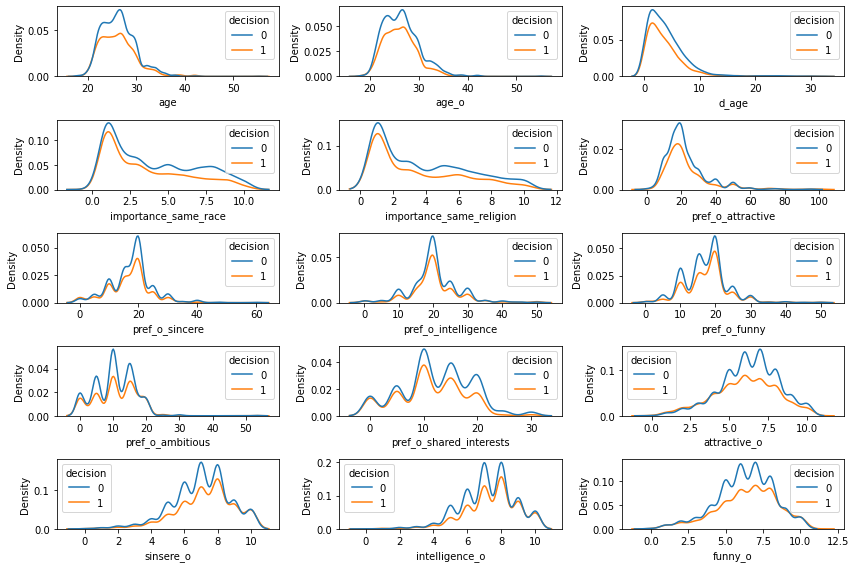

In [ ]:
col_list = [col for col in train_data.columns
            if col not in ['expected_num_interested_in_me', 
                           'decision', 'decision_o', 'match']]
col_list = [col for col in col_list if col not in cat_col_list]

fig = plt.figure(figsize=(12, 8))
for i in range(15):
  temp_data = train_data[train_data[col_list[i]]!='?'].copy()
  temp_data[col_list[i]] = temp_data[col_list[i]].astype(float)
  plt.subplot(5, 3, i+1)
  sns.kdeplot(x=col_list[i], data=temp_data, hue='decision')
plt.tight_layout()

The hypothesis derived from the plots above and 2 plots below are:
1. people from some age group (21-31) are more prone to negative decision
2. negative decision probability increases if a partner is from some age group (21-35)
3. negative decision probability increases if age difference is in some range (1-10)
4. people, who care about a partner being of same race or religion, are more prone to negative decision
5. negative decision probability increases based on partner's preference of attractiveness, sincerity, intelligence, funny, ambitious, and shared interests
6. negative decision probability increases based on partner's rating (about me) of attractiveness, sincerity, intelligence, funny, ambitious, and shared interests


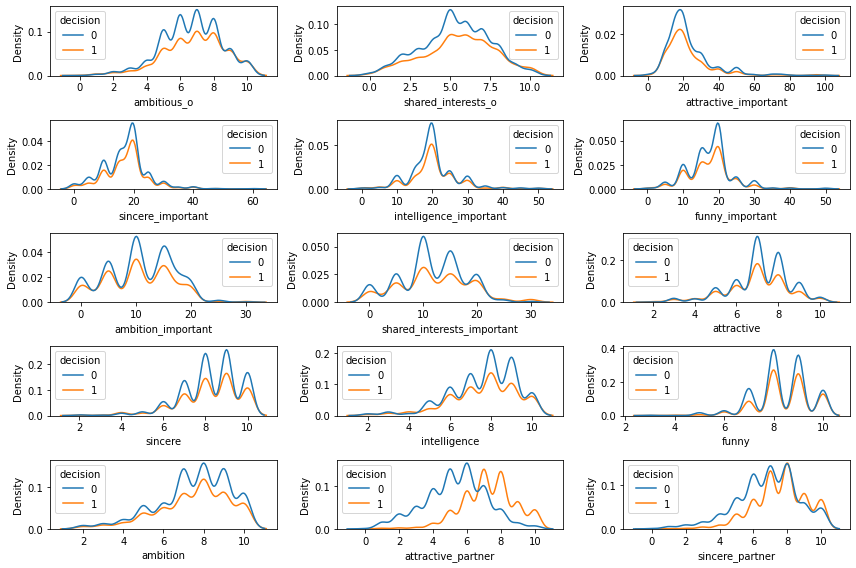

In [ ]:
fig = plt.figure(figsize=(12, 8))
for i in range(15, 30):
  temp_data = train_data[train_data[col_list[i]]!='?'].copy()
  temp_data[col_list[i]] = temp_data[col_list[i]].astype(float)
  plt.subplot(5, 3, i-14)
  sns.kdeplot(x=col_list[i], data=temp_data, hue='decision')
plt.tight_layout()

The hypothesis derived from the plots above and 4 plots below:
1. negative decision probability increases based on importance (for me) of attractiveness, sincerity, intelligence, funny, ambitious, and shared interests: less someone rates them more she/he is prone to negative outcome
2. negative decision probability increases based on self-rating of attractiveness, sincerity, intelligence, funny, ambitious, and shared interests: more someone rates herself/himself more she/he is prone to negative outcome
3. negative decision probability increases based on rating of attractiveness, sincerity, intelligence, funny, ambitious, and shared interests about partner: less someone rates partner more she/he is prone to negative outcome and vice versa

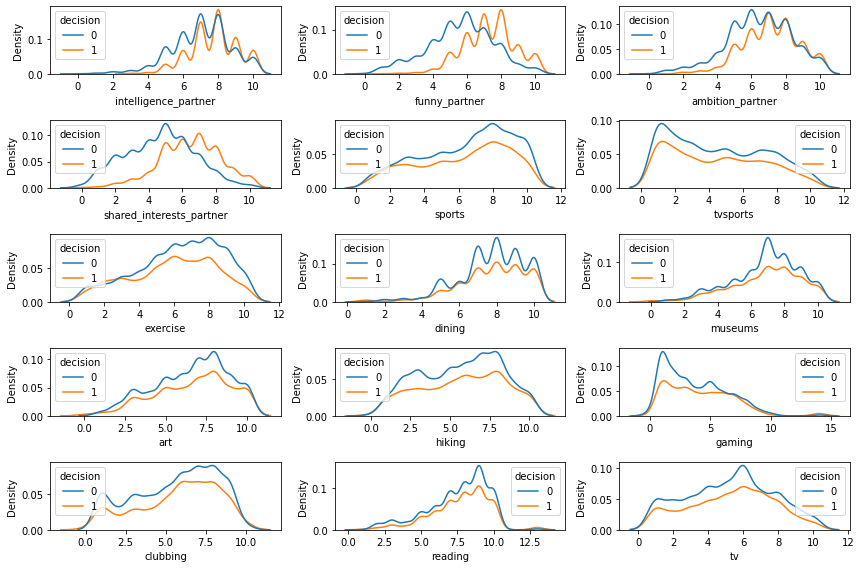

In [ ]:
fig = plt.figure(figsize=(12, 8))
for i in range(30, 45):
  temp_data = train_data[train_data[col_list[i]]!='?'].copy()
  temp_data[col_list[i]] = temp_data[col_list[i]].astype(float)
  plt.subplot(5, 3, i-29)
  sns.kdeplot(x=col_list[i], data=temp_data, hue='decision')
plt.tight_layout()

The hypothesis derived from the plots above and 7 plots below:
1. negative decision probability increases based on a person's rating of interests: dining and gaming
2. positive interest correlation does not guarantee that the decision will be positive

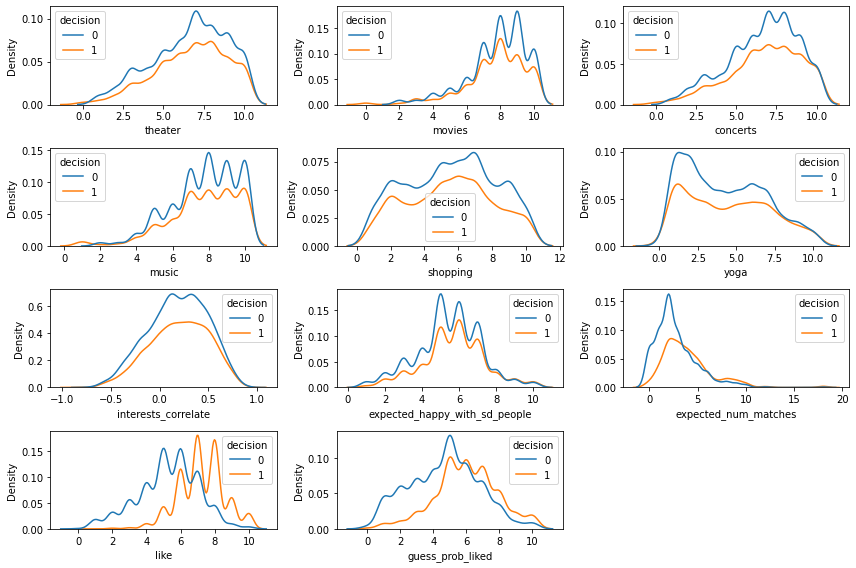

In [ ]:
fig = plt.figure(figsize=(12, 8))
for i in range(45, 56):
  temp_data = train_data[train_data[col_list[i]]!='?'].copy()
  temp_data[col_list[i]] = temp_data[col_list[i]].astype(float)
  plt.subplot(4, 3, i-44)
  sns.kdeplot(x=col_list[i], data=temp_data, hue='decision')
plt.tight_layout()

The hypothesis derived from the plots above:
1. people, expecting to be less happy with speed-dating partners, are more prone to negative decision
2. people, expecting less matches, are more prone to negative decision
3. more someone likes a partner more she/he is prone to positive decision and vice versa
4. more someone expects a partner likes her/him more she/he is prone to positive decision and vice versa

Though missing value imputation is a part of feature engineering, let's apply it before moving on. The reason is that for further analysis mutual info will be used which requires missing values to be imputed.
<br> Let's start with label encoding for categorical variables.

In [ ]:
cat_col_list2 = ['gender', 'race', 'race_o', 'field']

label_dic = {}
for col in cat_col_list2:
  temp_list = [i for i in X_train[col].unique() if i!='?']
  temp_map_dic = {temp_list[i]: i for i in range(len(temp_list))}
  X_train[col] = X_train[col].map(temp_map_dic)
  train_data[col] = train_data[col].map(temp_map_dic)

  temp_value_list = [i for i in X_test[col].unique() 
                     if i not in temp_map_dic.keys() and i!='?']
  if len(temp_value_list) == 0:
    X_test[col] = X_test[col].map(temp_map_dic)
  else:
    temp_map_dic.update({temp_value_list[i]: i+len(temp_list) 
                         for i in range(len(temp_value_list))})
    X_test[col] = X_test[col].map(temp_map_dic)

  label_dic[col] = {temp_map_dic[i]: i for i in temp_map_dic.keys()}

print(label_dic)

{'gender': {0: 'female', 1: 'male'}, 'race': {0: 'Asian/Pacific Islander/Asian-American', 1: 'European/Caucasian-American', 2: 'Other', 3: 'Latino/Hispanic American', 4: 'Black/African American'}, 'race_o': {0: 'European/Caucasian-American', 1: 'Asian/Pacific Islander/Asian-American', 2: 'Latino/Hispanic American', 3: 'Other', 4: 'Black/African American'}, 'field': {0: 'law', 1: 'masters in public administration', 2: 'masters of social work&education', 3: 'finance', 4: 'business', 5: 'political science', 6: 'psychology', 7: 'social work', 8: 'speech language pathology', 9: 'speech languahe pathology', 10: 'applied maths/econs', 11: 'mathematics', 12: 'statistics', 13: 'organizational psychology', 14: 'operations research', 15: 'mechanical engineering', 16: 'economics', 17: 'finanace', 18: 'undergrad - gs', 19: 'mathematical finance', 20: 'medicine', 21: 'german literature', 22: 'mba', 23: 'engineering', 24: 'classics', 25: 'operations research [seas]', 26: 'microbiology', 27: 'masters 

For missing value imputation KNNImputer will be used. Let's convert missing values ('?') to NA and creat boolean columns indicating whether a feature is missing or not.

In [ ]:
def str_to_num(x):
  if x == '?':
    return np.nan
  else:
    return float(x)

X_train = X_train.apply(lambda x: x.apply(str_to_num), axis=1)
X_test = X_test.apply(lambda x: x.apply(str_to_num), axis=1)

for col in X_train.columns:
  if X_train[col].isnull().sum() != 0:
    X_train[col+'_isna'] = X_train[col].apply(lambda x: 1 if pd.isna(x) else 0)
    X_test[col+'_isna'] = X_test[col].apply(lambda x: 1 if pd.isna(x) else 0)

isna_col_list = [col for col in X_train.columns if col.endswith('_isna')]

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
reduced_X_train = X_train[[col for col in X_train.columns 
                           if col not in isna_col_list]]
knn_imputer.fit(reduced_X_train)
transformed_X_train = pd.DataFrame(knn_imputer.transform(reduced_X_train))
transformed_X_train.columns = reduced_X_train.columns
transformed_X_train['d_age'] = transformed_X_train['age_o'] - \
                               transformed_X_train['age']
for col in cat_col_list:
    transformed_X_train[col] = np.round(transformed_X_train[col])
    #transformed_X_train[col] = transformed_X_train.astype(int)
X_train = pd.concat([transformed_X_train, X_train[isna_col_list]], axis=1)
display(X_train.head())

train_data = pd.concat([transformed_X_train, y_train], axis=1, sort=False)

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitious_o,shared_interests_o,attractive_important,sincere_important,intelligence_important,funny_important,ambition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,...,sincere_important_isna,intelligence_important_isna,funny_important_isna,ambition_important_isna,shared_interests_important_isna,attractive_isna,sincere_isna,intelligence_isna,funny_isna,ambition_isna,attractive_partner_isna,sincere_partner_isna,intelligence_partner_isna,funny_partner_isna,ambition_partner_isna,shared_interests_partner_isna,sports_isna,tvsports_isna,exercise_isna,dining_isna,museums_isna,art_isna,hiking_isna,gaming_isna,clubbing_isna,reading_isna,tv_isna,theater_isna,movies_isna,concerts_isna,music_isna,shopping_isna,yoga_isna,interests_correlate_isna,expected_happy_with_sd_people_isna,expected_num_interested_in_me_isna,expected_num_matches_isna,like_isna,guess_prob_liked_isna,met_isna
0,0.0,21.0,27.0,6.0,0.0,0.0,0.0,2.0,4.0,0.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,21.0,22.0,1.0,0.0,0.0,0.0,2.0,4.0,0.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,21.0,22.0,1.0,0.0,1.0,1.0,2.0,4.0,0.0,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,8.0,9.0,8.0,5.0,7.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,21.0,23.0,2.0,0.0,0.0,0.0,2.0,4.0,0.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,21.0,24.0,3.0,0.0,2.0,0.0,2.0,4.0,0.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
reduced_X_test = X_test[[col for col in X_test.columns 
                         if col not in isna_col_list]]
transformed_X_test = pd.DataFrame(knn_imputer.transform(reduced_X_test))
transformed_X_test.columns = reduced_X_test.columns
transformed_X_test['d_age'] = transformed_X_test['age_o'] - \
                              transformed_X_test['age']
for col in cat_col_list:
    transformed_X_test[col] = np.round(transformed_X_test[col])
    #transformed_X_test[col] = transformed_X_test.astype(int)
X_test = pd.concat([transformed_X_test, X_test[isna_col_list]], axis=1)
X_test.head()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitious_o,shared_interests_o,attractive_important,sincere_important,intelligence_important,funny_important,ambition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,...,sincere_important_isna,intelligence_important_isna,funny_important_isna,ambition_important_isna,shared_interests_important_isna,attractive_isna,sincere_isna,intelligence_isna,funny_isna,ambition_isna,attractive_partner_isna,sincere_partner_isna,intelligence_partner_isna,funny_partner_isna,ambition_partner_isna,shared_interests_partner_isna,sports_isna,tvsports_isna,exercise_isna,dining_isna,museums_isna,art_isna,hiking_isna,gaming_isna,clubbing_isna,reading_isna,tv_isna,theater_isna,movies_isna,concerts_isna,music_isna,shopping_isna,yoga_isna,interests_correlate_isna,expected_happy_with_sd_people_isna,expected_num_interested_in_me_isna,expected_num_matches_isna,like_isna,guess_prob_liked_isna,met_isna
0,0.0,25.0,27.0,2.0,1.0,0.0,1.0,8.0,4.0,16.0,35.0,20.0,20.0,20.0,0.0,5.0,7.0,8.0,6.0,5.0,8.0,4.0,35.0,10.0,35.0,10.0,10.0,0.0,8.0,9.0,8.0,9.0,8.0,7.0,9.0,10.0,7.0,8.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.0,25.0,22.0,-3.0,1.0,0.0,1.0,8.0,4.0,16.0,60.0,0.0,0.0,40.0,0.0,0.0,6.0,7.0,10.0,6.0,6.0,5.0,35.0,10.0,35.0,10.0,10.0,0.0,8.0,9.0,8.0,9.0,8.0,9.0,7.0,9.0,8.0,9.0,7.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.0,25.0,22.0,-3.0,1.0,1.0,0.0,8.0,4.0,16.0,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,35.0,10.0,35.0,10.0,10.0,0.0,8.0,9.0,8.0,9.0,8.0,7.0,9.0,9.0,7.0,9.0,7.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.0,25.0,23.0,-2.0,1.0,0.0,1.0,8.0,4.0,16.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,9.0,8.0,8.0,8.0,8.0,35.0,10.0,35.0,10.0,10.0,0.0,8.0,9.0,8.0,9.0,8.0,9.0,7.0,9.0,7.0,9.0,7.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.0,25.0,24.0,-1.0,1.0,2.0,0.0,8.0,4.0,16.0,30.0,10.0,20.0,10.0,10.0,20.0,6.0,10.0,8.0,6.0,7.2,5.4,35.0,10.0,35.0,10.0,10.0,0.0,8.0,9.0,8.0,9.0,8.0,9.0,10.0,10.0,10.0,10.0,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Let's derive mutual info scores ignoring partner preferences for the characteristics and their opinion about you (dating partner): as those are not known to a decision maker.

In [ ]:
int_col_list = cat_col_list.copy()
int_col_list.extend(['age', 'age_o', 'd_age'])

for col in int_col_list:
    X_train[col] = X_train[col].apply(lambda x: np.round(x)).astype(int)
    X_test[col] = X_test[col].apply(lambda x: np.round(x)).astype(int)

X_train_sub = X_train[[col for col in X_train.columns 
                       if col not in isna_col_list]]

partner_pref_list = [col for col in X_train_sub.columns 
                     if col.startswith('pref_o')]
partner_opinion_list = [col for col in X_train_sub.columns 
                        if col.endswith('_o') 
                        and col not in ['age_o', 'race_o']]
exclude_columns_list = []
exclude_columns_list.extend(partner_pref_list)
exclude_columns_list.extend(partner_opinion_list)
X_train_sub = X_train_sub[[col for col in X_train_sub.columns 
                           if col not in exclude_columns_list]]
                           
discrete_features = X_train_sub.dtypes == int

In [ ]:
def get_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X=X, y=y, 
                                    discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI_Scores', index=X.columns)
    mi_scores.sort_values(ascending=False, inplace=True)
    return mi_scores

mi_scores = get_mi_scores(X=X_train_sub, y=y_train, 
                          discrete_features=discrete_features)

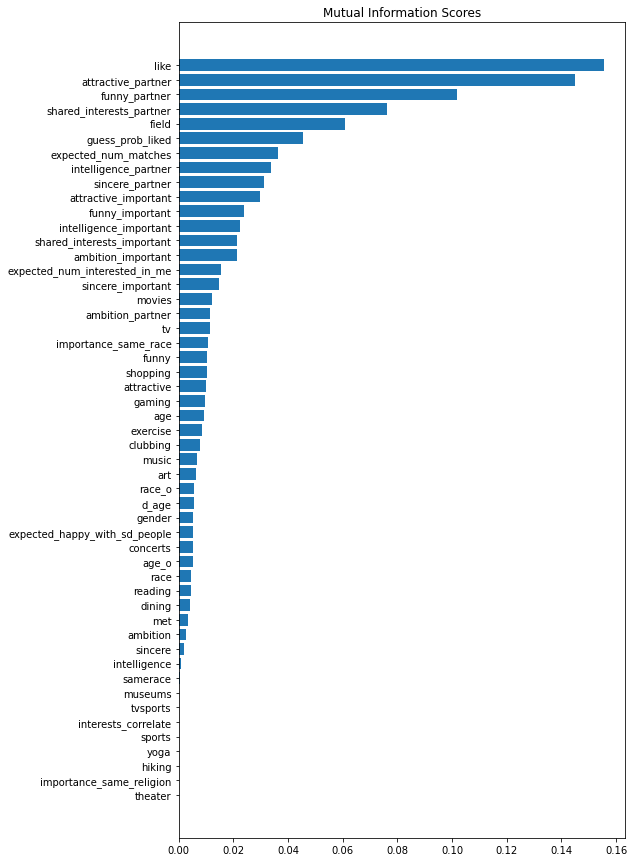

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(figsize=(8, 15))
plot_mi_scores(mi_scores)

### Bivariate analysis

Let's create iteraction features using categorical variables and calculate mutual info score with regard to target (it takes around 20 minutes to run).

In [ ]:
mi_score_iter_dic = {}
for col1 in cat_col_list:
  for col2 in [col for col in X_train_sub.columns if col != col1]:
    if col2 in exclude_columns_list:
      continue
    if col1+'__'+col2 not in mi_score_iter_dic.keys():
      X_train_sub[col2+'__'+col1] = X_train_sub[col2] * X_train_sub[col1]
      discrete_features = X_train_sub.dtypes == int
      mi_scores = get_mi_scores(X=X_train_sub, y=y_train, 
                                discrete_features=discrete_features)
      mi_score_iter_dic[col2+'__'+col1] = mi_scores.loc[col2+'__'+col1]
      X_train_sub.drop(col2+'__'+col1, axis=1, inplace=True)

Let's create iteraction features using the other variables and calculate mutual info score with regard to target (this takes around 1.5 hours to run).

In [ ]:
rating_col_list = [col for col in X_train_sub.columns 
                   if col not in cat_col_list 
                   and col not in exclude_columns_list]
for col1 in rating_col_list:
  for col2 in [col for col in rating_col_list if col != col1]:
    if col1+'__'+col2 not in mi_score_iter_dic.keys():
      X_train_sub[col2+'__'+col1] = X_train_sub[col2] * X_train_sub[col1]
      discrete_features = X_train_sub.dtypes == int
      mi_scores = get_mi_scores(X=X_train_sub, y=y_train, 
                                discrete_features=discrete_features)
      mi_score_iter_dic[col2+'__'+col1] = mi_scores.loc[col2+'__'+col1]
      X_train_sub.drop(col2+'__'+col1, axis=1, inplace=True)

Choosing iteraction variables with mutual info greater than 0.13 (chosen taking into account the mutual info scores' plot above)

In [ ]:
# import pickle
# with open('mi_score_dic.txt', 'rb') as file:
#   mi_score_iter_dic = pickle.load(file)

In [ ]:
iter_vars = [i for i in mi_score_iter_dic if mi_score_iter_dic[i]>0.13]
iter_vars

['age_o__field',
 'd_age__field',
 'attractive_partner__age',
 'like__age',
 'like__age_o',
 'like__sincere',
 'like__funny',
 'funny_partner__attractive_partner',
 'shared_interests_partner__attractive_partner',
 'like__attractive_partner',
 'guess_prob_liked__attractive_partner',
 'like__sincere_partner',
 'like__intelligence_partner',
 'like__funny_partner',
 'like__shared_interests_partner']

Showing the scores for the chosen iteraction variables

In [ ]:
# import pickle
# with open('mi_score_dic.txt', 'wb') as file:
#   pickle.dump(mi_score_iter_dic, file)

In [ ]:
selected_iter_list = []
mi_score_list = []
for i in iter_vars:
  selected_iter_list.append(i)
  mi_score_list.append(mi_score_iter_dic[i])
mi_score_dt = pd.DataFrame()
mi_score_dt['Iteraction'] = selected_iter_list
mi_score_dt['MI score'] = mi_score_list
mi_score_dt.sort_values('MI score', inplace=True, ascending=False)
mi_score_dt.reset_index(drop=True, inplace=True)
mi_score_dt#.head(15)
#print(f'{i}: {mi_score_iter_dic[i]}')

,Iteraction,MI score
0,like__attractive_partner,0.191689
1,age_o__field,0.169526
2,like__age,0.162814
3,like__funny_partner,0.160074
4,funny_partner__attractive_partner,0.159374
5,like__age_o,0.152020
6,like__funny,0.150391
7,shared_interests_partner__attractive_partner,0.149604
8,like__intelligence_partner,0.147493
9,attractive_partner__age,0.144294


Let's plot the scatter plots of iteraction combinations above. As there are 15 combinations, let's plot them using 1 panel with 15 subplots.

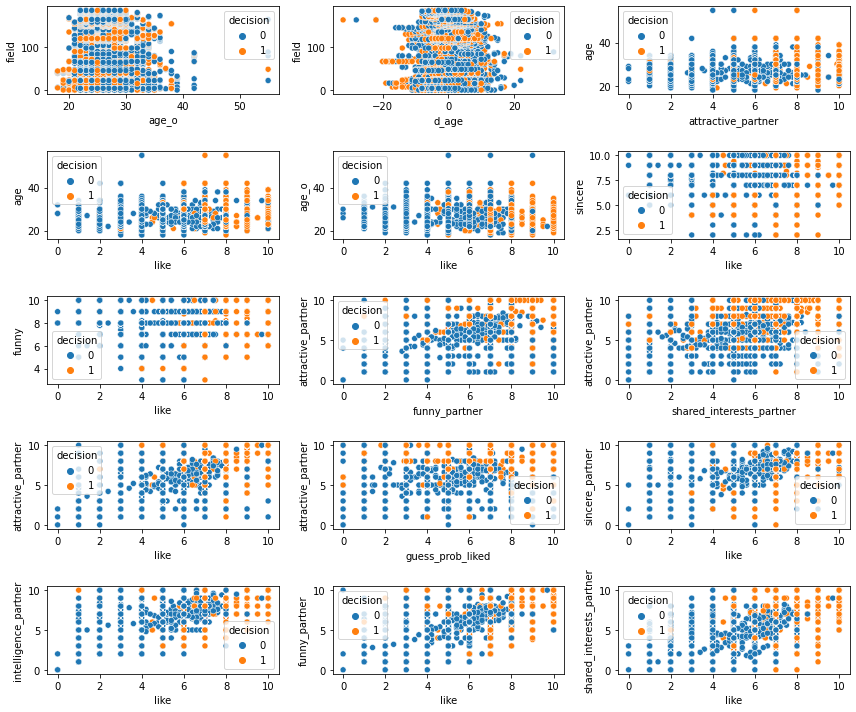

In [ ]:
fig = plt.figure(figsize=(12, 10))
for i in range(15):
  temp_col1 = selected_iter_list[i].split('__')[0]
  temp_col2 = selected_iter_list[i].split('__')[1]
  plt.subplot(5, 3, i+1)
  sns.scatterplot(x=temp_col1, y=temp_col2, 
                  data=train_data, hue='decision')
plt.tight_layout()

The plots above show that 
1. if attractevness of a partner (attractive_partner) is rated above 8, positive decisions dominate. Let's check this.

In [ ]:
train_data[train_data['attractive_partner']>8]['decision'].value_counts(normalize=True)

1    0.822556
0    0.177444
Name: decision, dtype: float64

In [ ]:
train_data[train_data['attractive_partner']<8]['decision'].value_counts(normalize=True)

0    0.694507
1    0.305493
Name: decision, dtype: float64

2. if age of self (age) is greater than 40 and attractevness of a partner (attractive_partner) is rated 6 and above, positive decision dominates.

In [ ]:
train_data[(train_data['age']>=40) & 
           (train_data['attractive_partner']>=6)]['decision'].\
           value_counts(normalize=True)

1    0.894737
0    0.105263
Name: decision, dtype: float64

3. if someone rates how much she/he likes a partner higher than 8, positive decisions dominate.

In [ ]:
train_data[train_data['like']>8]['decision'].value_counts(normalize=True)

1    0.849257
0    0.150743
Name: decision, dtype: float64

In [ ]:
train_data[train_data['like']<8]['decision'].value_counts(normalize=True)

0    0.687587
1    0.312413
Name: decision, dtype: float64

4. if someone rates how much she/he likes a partner 4 or less then negative decision dominates

In [ ]:
train_data[train_data['like']<=4]['decision'].value_counts(normalize=True)

0    0.945255
1    0.054745
Name: decision, dtype: float64

5. if someone rates how much she/he likes a partner 6 or higher and self age is 40 and above, positive decision dominates.

In [ ]:
train_data[(train_data['age']>=40) & 
           (train_data['like']>=6)]['decision'].\
           value_counts(normalize=True)

1    1.0
Name: decision, dtype: float64

6. if age of a partner is 40 and above then negative decision dominates

In [ ]:
train_data[train_data['age_o']>=40]['decision'].value_counts(normalize=True)

0    0.761905
1    0.238095
Name: decision, dtype: float64

7. if attractivness of a partner (attractive_partner) is rated less than 4, negative decision dominates.

In [ ]:
train_data[train_data['attractive_partner']<4]['decision'].value_counts(normalize=True)

0    0.93719
1    0.06281
Name: decision, dtype: float64

8. If self sincerity is rated 4 or less and rating of how much she/he likes a partner is 8 or above, positive decisions dominate.

In [ ]:
train_data[(train_data['sincere']<=4) & 
           (train_data['like']>=8)]['decision'].\
           value_counts(normalize=True)

1    0.866667
0    0.133333
Name: decision, dtype: float64

9. If self sincerity is rated 6 or more and rating of how much she/he likes a partner is 4 or below, negative decisions dominate.

In [ ]:
train_data[(train_data['sincere']>=6) & 
           (train_data['like']<=4)]['decision'].\
           value_counts(normalize=True)

0    0.952381
1    0.047619
Name: decision, dtype: float64

10. It seems that below a line, which has intercept 4/1.1 and some slope that is greater than 1, positive decisions dominate in funny vs attractive_partner and funny vs like plots.

In [ ]:
temp_data = train_data[['funny', 'attractive_partner', 'decision']]
temp_data['est_funny'] = 1.1*temp_data['attractive_partner'] - 4
temp_data['below_line'] = (temp_data['funny']<temp_data['est_funny']).astype(int)
temp_data[temp_data['below_line']==1]['decision'].value_counts(normalize=True)

1    0.9
0    0.1
Name: decision, dtype: float64

In [ ]:
temp_data = train_data[['funny', 'like', 'decision']]
temp_data['est_funny'] = 1.1*temp_data['like'] - 4
temp_data['below_line'] = (temp_data['funny']<temp_data['est_funny']).astype(int)
temp_data[temp_data['below_line']==1]['decision'].value_counts(normalize=True)

1    0.875
0    0.125
Name: decision, dtype: float64

11. If partner's attractiveness is rated 6 or above and intelligence 9 or above, then positive decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']>6) & 
           (train_data['intelligence_partner']>=9)]['decision'].\
           value_counts(normalize=True)

1    0.730769
0    0.269231
Name: decision, dtype: float64

12. If partner's attractiveness is rated below 5 and intelligence below 8, then negative decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']<5) & 
           (train_data['intelligence_partner']<8)]['decision'].\
           value_counts(normalize=True)

0    0.929426
1    0.070574
Name: decision, dtype: float64

13. If partner's attractiveness is rated below 5 and sense humor (funny) below 8, then negative decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']<5) & 
           (train_data['funny_partner']<8)]['decision'].\
           value_counts(normalize=True)

0    0.922662
1    0.077338
Name: decision, dtype: float64

14. If partner's attractiveness is rated above 8 and sense of humor (funny) above 8, then positive decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']>8) & 
           (train_data['funny_partner']>8)]['decision'].\
           value_counts(normalize=True)

1    0.873065
0    0.126935
Name: decision, dtype: float64

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# for i in range(12, 15):
#   temp_col1 = selected_iter_list[i].split('__')[0]
#   temp_col2 = selected_iter_list[i].split('__')[1]
#   plt.subplot(4, 3, i-11)
#   sns.scatterplot(x=temp_col1, y=temp_col2, 
#                   data=train_data, hue='decision')
# plt.tight_layout()

15. If partner's attractiveness is rated below 5 and shared interests below 8, then negative decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']<5) & 
           (train_data['shared_interests_partner']<8)]['decision'].\
           value_counts(normalize=True)

0    0.922739
1    0.077261
Name: decision, dtype: float64

16. If partner's attractiveness is rated above 6 and shared interests above 8, then positive decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']>6) & 
           (train_data['shared_interests_partner']>8)]['decision'].\
           value_counts(normalize=True)

1    0.863768
0    0.136232
Name: decision, dtype: float64

17. If partner's attractiveness is rated below 5 and how she/he likes a partner is rated below 8, then negative decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']<5) & 
           (train_data['like']<8)]['decision'].\
           value_counts(normalize=True)

0    0.925606
1    0.074394
Name: decision, dtype: float64

18. If partner's attractiveness is rated above 5 and how she/he likes a partner is rated above 8, then positive decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']>5) & 
           (train_data['like']>8)]['decision'].\
           value_counts(normalize=True)

1    0.87472
0    0.12528
Name: decision, dtype: float64

19. If partner's attractiveness is rated below 5 and how a partner likes you is rated below 8, then negative decisions dominate.

In [ ]:
train_data[(train_data['attractive_partner']<5) & 
           (train_data['guess_prob_liked']<8)]['decision'].\
           value_counts(normalize=True)

0    0.927171
1    0.072829
Name: decision, dtype: float64

20. if partner's sincerity is rated above 5 and how she/he likes a partner is rated above 8, then positive decisions dominate

In [ ]:
train_data[(train_data['sincere_partner']>5) & 
           (train_data['like']>8)]['decision'].\
           value_counts(normalize=True)

1    0.851931
0    0.148069
Name: decision, dtype: float64

21. if partner's intelligence is rated above 5 and how she/he likes a partner is rated above 8, then positive decisions dominate

In [ ]:
train_data[(train_data['intelligence_partner']>5) & 
           (train_data['like']>8)]['decision'].\
           value_counts(normalize=True)

1    0.848614
0    0.151386
Name: decision, dtype: float64

22. if partner's sense of humor (funny) is rated above 5 and how she/he likes a partner is rated above 8, then positive decisions dominate

In [ ]:
train_data[(train_data['funny_partner']>5) & 
           (train_data['like']>8)]['decision'].\
           value_counts(normalize=True)

1    0.853712
0    0.146288
Name: decision, dtype: float64

23. if shared interests with a partner is rated above 5 and how she/he likes a partner is rated above 8, then positive decisions dominate

In [ ]:
train_data[(train_data['shared_interests_partner']>5) & 
           (train_data['like']>8)]['decision'].\
           value_counts(normalize=True)

1    0.859447
0    0.140553
Name: decision, dtype: float64

24. if how she/he likes a partner is rated below 6 and how a partner likes you is rated below 8, then negative decisions dominate

In [ ]:
train_data[(train_data['like']<6) & 
           (train_data['guess_prob_liked']<8)]['decision'].\
           value_counts(normalize=True)

0    0.884337
1    0.115663
Name: decision, dtype: float64

Next let's see what characterics drive positive decision formation by gender.

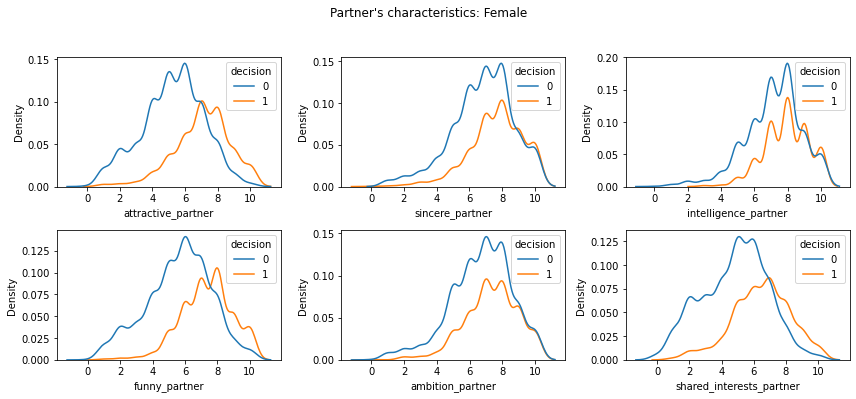

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[train_data['gender']==0], hue='decision')
plt.suptitle("Partner's characteristics: Female", y=1.1)
plt.tight_layout()

Based on the plots above sincerity, intelligence, and ambition don't matter for females: there is no any threshold after which positive decisions dominate. Though we can see that 8 is something like a psychological threshold for these characteristics: before reaching this level positive decisions increase, then after that point decrease. Let's show the importance of each characteric for female.

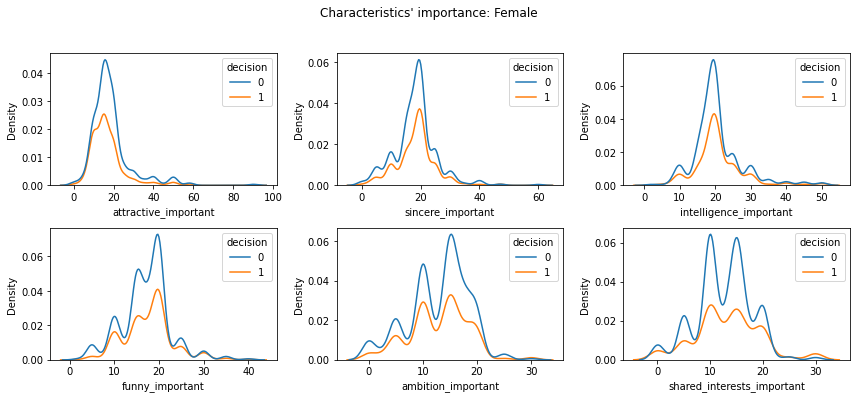

In [ ]:
importance_chars = ['attractive_important', 'sincere_important', 
                    'intelligence_important', 'funny_important', 
                    'ambition_important', 'shared_interests_important']

fig = plt.figure(figsize=(12, 5))
for i in range(len(importance_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=importance_chars[i], 
              data=train_data[train_data['gender']==0], hue='decision')
plt.suptitle("Characteristics' importance: Female", y=1.1)
plt.tight_layout()

The plots above show that there is no any charecteric that drives decisions of females: there is no any threshold after which positive decisions dominate. Though we can see that there is something like a psychological threshold which varies by the characteristics: before reaching this level positive decisions increase, then after that point decrease.

Let's what we can find for males.

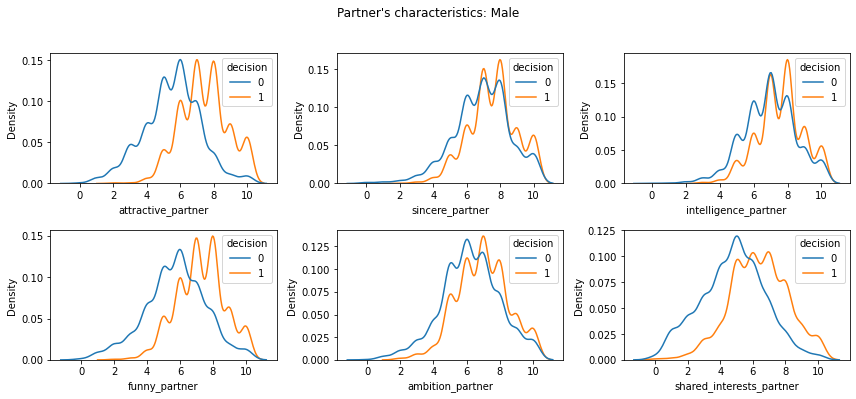

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[train_data['gender']==1], hue='decision')
plt.suptitle("Partner's characteristics: Male", y=1.1)
plt.tight_layout()

The plots above show that there is a threshold for each characteristic after which positive decisions dominate. Moreover before reaching those thresholds positive decisions increase after that they decrease.

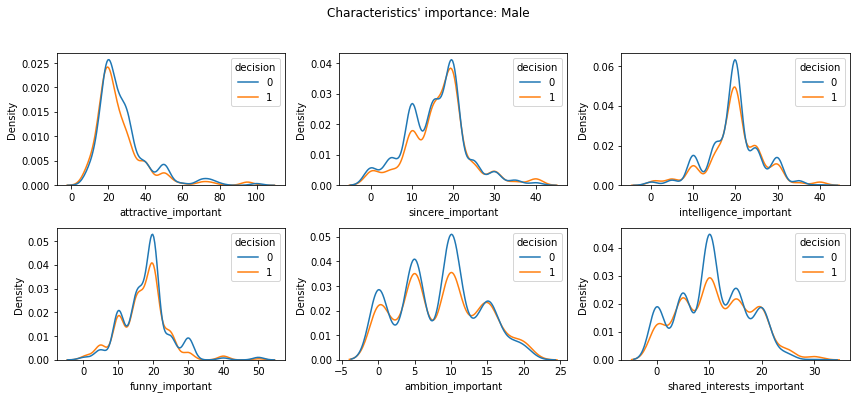

In [ ]:
importance_chars = ['attractive_important', 'sincere_important', 
                    'intelligence_important', 'funny_important', 
                    'ambition_important', 'shared_interests_important']

fig = plt.figure(figsize=(12, 5))
for i in range(len(importance_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=importance_chars[i], 
              data=train_data[train_data['gender']==1], hue='decision')
plt.suptitle("Characteristics' importance: Male", y=1.1)
plt.tight_layout()

Judging by the plots above there is no any charecteric that drives decisions of males: there is no any threshold after which positive decisions dominate. Though we can see that there is something like a psychological threshold which varies by the characteristics: before reaching this level positive decisions increase, then after that point decrease.

### Multivariate analysis

Let's compute mutual info scores for triple iteraction. This iteraction contains 2 rating variables and 1 categorical. The latter is either gender or samerace (it takes about 2 hours and 40 minutes to run the code).

In [ ]:
rating_col_list = [col for col in X_train_sub.columns 
                   if col not in cat_col_list]
mi_score_miter_dic = {}
for col1 in ['gender', 'samerace']:
  for col2 in rating_col_list:
    for col3 in [col for col in rating_col_list if col != col2]:
      if col1+'__'+col2+'__'+col3 not in mi_score_miter_dic.keys():
        X_train_sub[col1+'__'+col3+'__'+col2] = X_train_sub[col2] * X_train_sub[col1] * X_train_sub[col3]
        discrete_features = X_train_sub.dtypes == int
        mi_scores = get_mi_scores(X=X_train_sub, y=y_train, 
                                  discrete_features=discrete_features)
        mi_score_miter_dic[col1+'__'+col3+'__'+col2] = mi_scores.loc[col1+'__'+col3+'__'+col2]
        X_train_sub.drop(col1+'__'+col3+'__'+col2, axis=1, inplace=True)

Now we can see which iteractions have mutual info score greater than 0.1 (0.13 threshold returns nothing).

In [ ]:
# import pickle
# with open('mi_score_miter_dic.txt', 'wb') as file:
#   pickle.dump(mi_score_miter_dic, file)

In [ ]:
[i for i in mi_score_miter_dic if mi_score_miter_dic[i]>0.1]

['gender__like__attractive_partner']

Let's plot the iteraction.

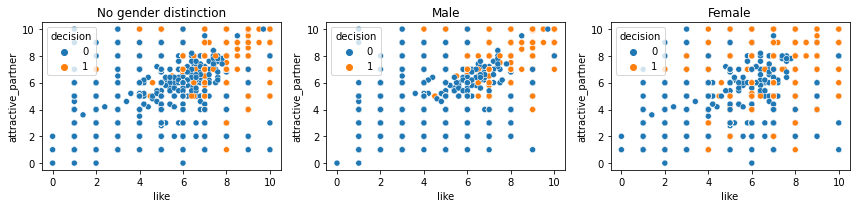

In [ ]:
fig = plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.scatterplot(x='like', y='attractive_partner', 
                  data=train_data, hue='decision')
plt.title('No gender distinction')
plt.subplot(1, 3, 2)
sns.scatterplot(x='like', y='attractive_partner', 
                  data=train_data[train_data['gender']==1], hue='decision')
plt.title('Male')
plt.subplot(1, 3, 3)
sns.scatterplot(x='like', y='attractive_partner', 
                  data=train_data[train_data['gender']==0], hue='decision')
plt.title('Female')
plt.tight_layout()

At least visually there is no any extraordinary difference that can be seen by gender distinction. Therefore it is not worth to consider this iteraction.

Let's check how the positive decisions are distributed by gender, age (median age is considered as a threshold), and partner's characteristics (rated by self). Females are condidered first.

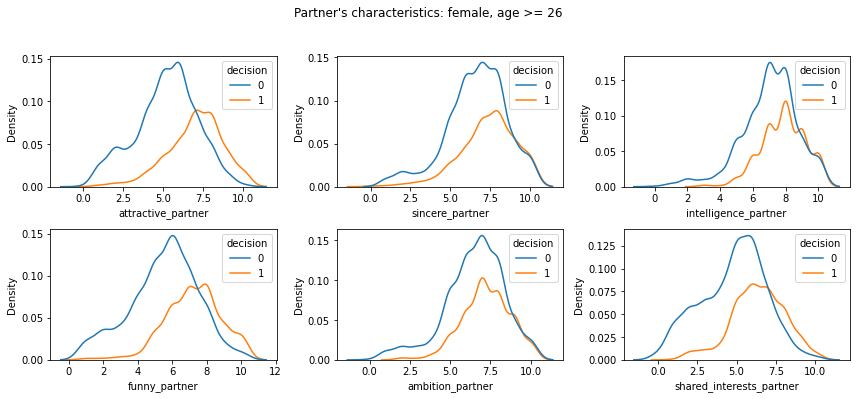

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

female_age_median = int(train_data[train_data['gender']==0]['age'].median())

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==0) 
                              & (train_data['age']>=female_age_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: female, age >= {female_age_median}", y=1.1)
plt.tight_layout()

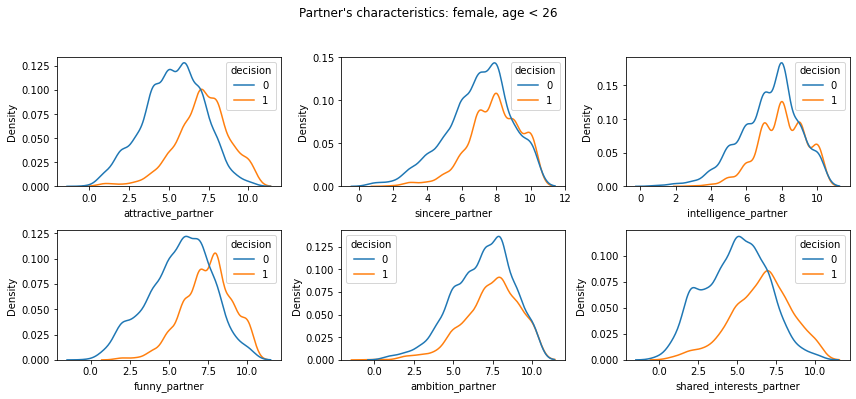

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==0) 
                              & (train_data['age']<female_age_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: female, age < {female_age_median}", y=1.1)
plt.tight_layout()

The two plots above show that there is no explicit difference for females above and below the median age. Let's check what's the case for males.

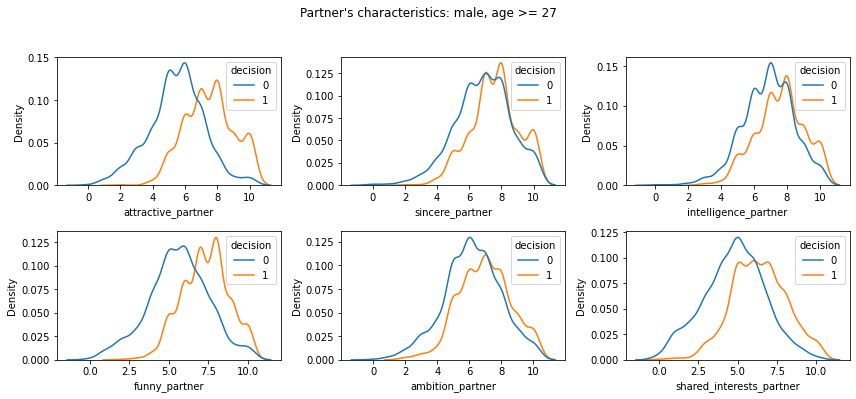

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

male_age_median = int(train_data[train_data['gender']==1]['age'].median())

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==1) 
                              & (train_data['age']>=male_age_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: male, age >= {male_age_median}", y=1.1)
plt.tight_layout()

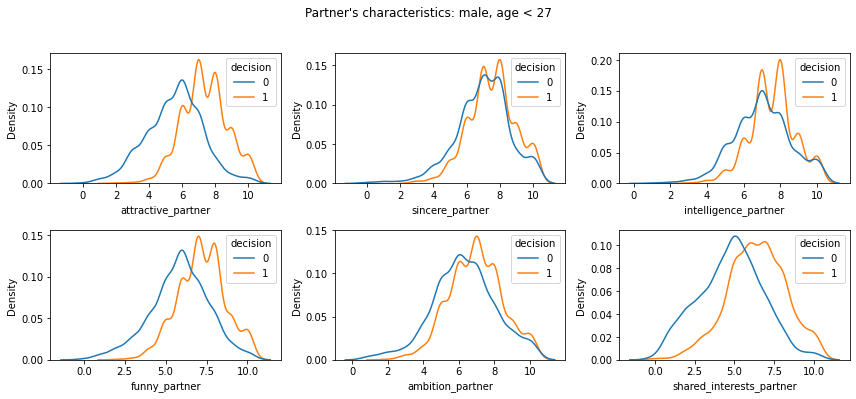

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==1) 
                              & (train_data['age']<male_age_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: male, age < {male_age_median}", y=1.1)
plt.tight_layout()

No explicit difference is found for males too. Let's consider age difference instead of age. Again let's explore females' decisions first.

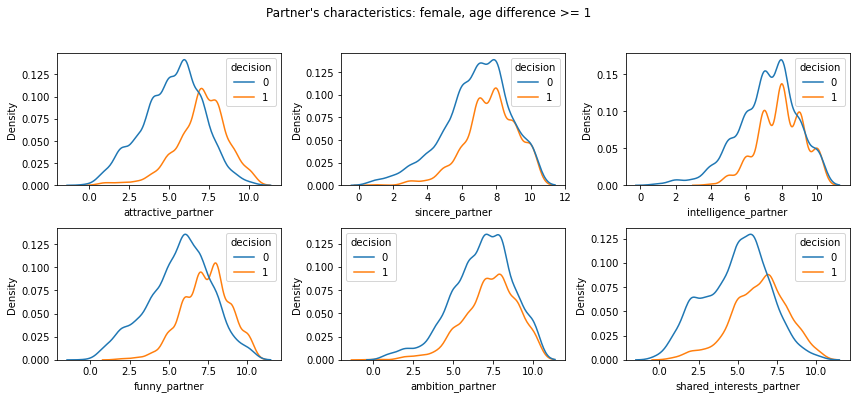

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

female_dage_median = int(train_data[train_data['gender']==0]['d_age'].median())

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==0) 
                              & (train_data['d_age']>=female_dage_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: female, age difference >= {female_dage_median}", y=1.1)
plt.tight_layout()

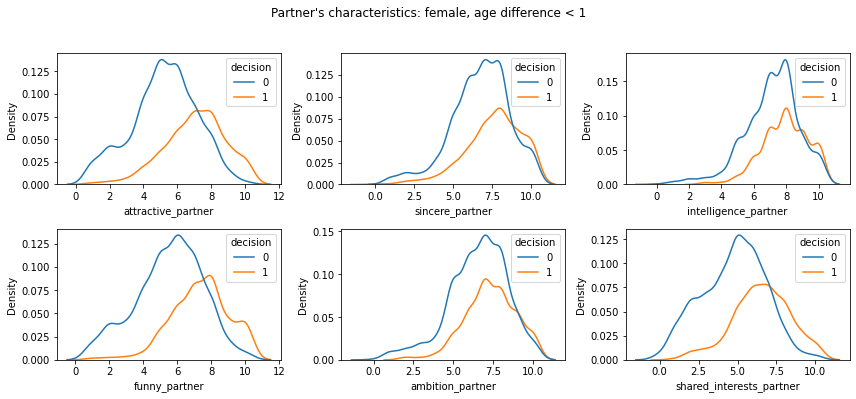

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==0) 
                              & (train_data['d_age']<female_dage_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: female, age difference < {female_dage_median}", y=1.1)
plt.tight_layout()

Visually there is no big difference for females in terms of age difference and partner's characteristics (rated by self). Let's see the situation with males.

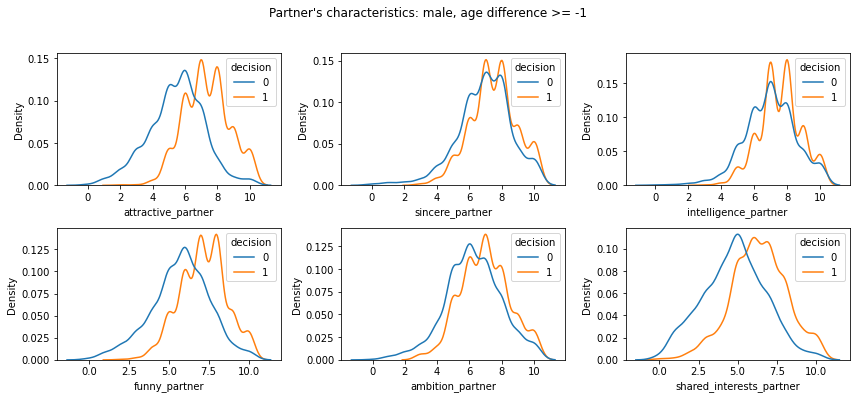

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

male_dage_median = int(train_data[train_data['gender']==1]['d_age'].median())

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==1) 
                              & (train_data['d_age']>=male_dage_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: male, age difference >= {male_dage_median}", y=1.1)
plt.tight_layout()

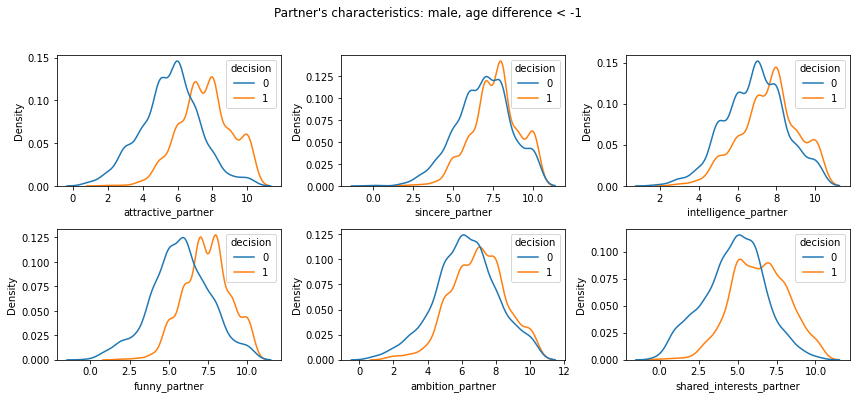

In [ ]:
partner_chars = ['attractive_partner', 'sincere_partner', 
                 'intelligence_partner', 'funny_partner', 
                 'ambition_partner', 'shared_interests_partner']

fig = plt.figure(figsize=(12, 5))
for i in range(len(partner_chars)):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(x=partner_chars[i], 
              data=train_data[(train_data['gender']==1) 
                              & (train_data['d_age']<male_dage_median)], 
              hue='decision')
plt.suptitle(f"Partner's characteristics: male, age difference < {male_dage_median}", y=1.1)
plt.tight_layout()

There is no obvious difference for males too. <br>But there is a threshold for each characteristic of a partner (rated by self) after which positive decisions start to decline. That is true for females and males above/below median age.The same holds if we consider age difference instead of age. We can also come to this conclusion looking at the appropriate plots in the univariate analysis section. <br> Next let's construct scatter plots for the characteristics' importance and a partners' characteristics (rated by self) by gender.

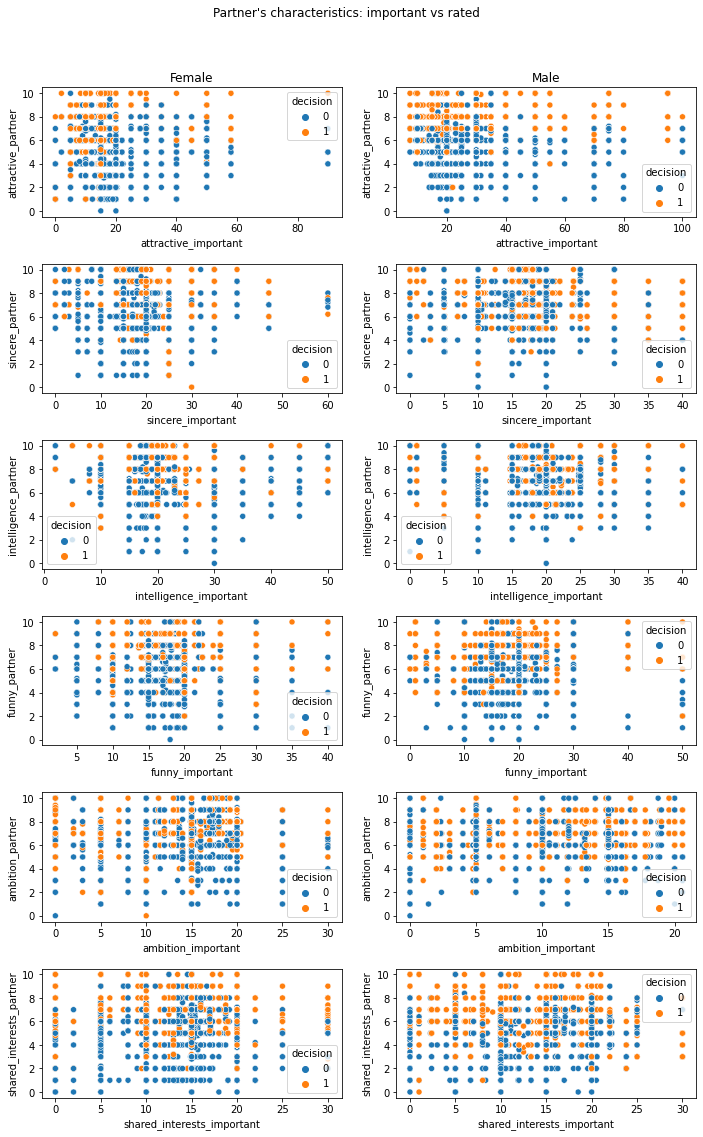

In [ ]:
chars_list = ['attractive', 'sincere', 'intelligence', 
              'funny', 'ambition', 'shared_interests']

fig = plt.figure(figsize=(10, 15))
for i in range(len(chars_list)):
  plt.subplot(len(chars_list), 2, 2*i+1)
  sns.scatterplot(x=f'{chars_list[i]}_important', y=f'{chars_list[i]}_partner', 
                  data=train_data[train_data['gender']==0], hue='decision')
  if i == 0:
    plt.title('Female')
  plt.subplot(len(chars_list), 2, 2*i+2)
  sns.scatterplot(x=f'{chars_list[i]}_important', y=f'{chars_list[i]}_partner', 
                  data=train_data[train_data['gender']==1], hue='decision')
  if i == 0:
    plt.title('Male')
plt.suptitle("Partner's characteristics: important vs rated", y=1.05)
plt.tight_layout()

From the plots above we observe:
1. there are more males (encoding is 1) rating attractiveness importance 60 and more than females

In [ ]:
train_data[train_data['attractive_important']>=60]['gender'].\
           value_counts(normalize=False)

1.0    127
0.0      8
Name: gender, dtype: int64

2. for males, if attractiveness importance is 60 and above and rated attractiveness of a partner is above 8, positive decisions dominate

In [ ]:
train_data[(train_data['attractive_important']>=60) & 
           (train_data['attractive_partner']>8) &
           (train_data['gender']==1)]['decision'].\
           value_counts(normalize=False)

1    19
0     1
Name: decision, dtype: int64

3. there are more females (encoding is 0) rating sincerity 60 and above than males

In [ ]:
train_data[train_data['sincere_important']>=60]['gender'].\
           value_counts(normalize=False)

0.0    7
Name: gender, dtype: int64

4. for females, if a partner's rated intelligence(intelligence_partner) is below 6 or 4 and below, negative decisions dominate

In [ ]:
train_data[(train_data['intelligence_partner']<6) &
           (train_data['gender']==0)]['decision'].\
           value_counts(normalize=True)

0    0.873315
1    0.126685
Name: decision, dtype: float64

In [ ]:
train_data[(train_data['intelligence_partner']<=4) &
           (train_data['gender']==0)]['decision'].\
           value_counts(normalize=True)

0    0.925373
1    0.074627
Name: decision, dtype: float64

5. for females, if a partner's rated sense of humour (funny_partner) is below a line passing through 1.5 (on funny_partner axis) with slope 0.1, negative decisions dominate

In [ ]:
temp_data = train_data[train_data['gender']==0][['funny_important', 'funny_partner', 'decision']]
temp_data['est_funny'] = 0.1*temp_data['funny_important'] + 1.5
temp_data['below_line'] = (temp_data['funny_partner']<temp_data['est_funny']).astype(int)
temp_data[temp_data['below_line']==1]['decision'].value_counts(normalize=True)

0    0.933086
1    0.066914
Name: decision, dtype: float64

6. for females, if a partner's attractiveness is 4 and below, negative decisions dominate

In [ ]:
train_data[(train_data['attractive_partner']<=4) &
           (train_data['gender']==0)]['decision'].\
           value_counts(normalize=True)

0    0.886179
1    0.113821
Name: decision, dtype: float64

7. for females, if a partner's rated sense of humour (funny_partner) is below a line passing through 30/2.5 (on funny_important axis) with slope -2.5, negative decisions dominate

In [ ]:
temp_data = train_data[train_data['gender']==0][['funny_important', 'funny_partner', 'decision']]
temp_data['est_funny'] = -2.5*temp_data['funny_important'] + 30
temp_data['below_line'] = (temp_data['funny_partner']<temp_data['est_funny']).astype(int)
temp_data[temp_data['below_line']==1]['decision'].value_counts(normalize=True)

0    0.830275
1    0.169725
Name: decision, dtype: float64

8. there are more females (encoding is 0) rating ambition 20 and more than males

In [ ]:
train_data[train_data['ambition_important']>=20]['gender'].\
           value_counts(normalize=False)

0.0    344
1.0     85
Name: gender, dtype: int64

In [ ]:
# def scale_to_01_range(x):
#     # compute the distribution range
#     value_range = (np.max(x) - np.min(x))

#     # move the distribution so that it starts from zero
#     # by extracting the minimal value from all its values
#     starts_from_zero = x - np.min(x)

#     # make the distribution fit [0; 1] by dividing by its range
#     return starts_from_zero / value_range

In [ ]:
# from sklearn.manifold import TSNE

# tsne_columns = ['gender', 'd_age', 'race', 'race_o', 'importance_same_race',
#                 'importance_same_religion', 'field', 'attractive_important',
#                 'sincere_important', 'intellicence_important', 'funny_important',
#                 'ambtition_important', 'shared_interests_important',
#                 'attractive_partner', 'sincere_partner', 'intelligence_partner',
#                 'funny_partner', 'ambition_partner', 'shared_interests_partner',
#                 'interests_correlate', 'met']
# features = train_data[tsne_columns]

# perplexity_list = [2, 5, 10, 20, 30, 50, 100, 200]
# colors_per_class = {0: 'green', 1: 'red'}

# fig = plt.figure(figsize=(12, 4))
# for i in range(len(perplexity_list)):
#     tsne = TSNE(n_components=2, 
#                 perplexity=perplexity_list[i]).\
#            fit_transform(features)
#     tx = tsne[:, 0]
#     ty = tsne[:, 1]
#     tx = scale_to_01_range(tx)
#     ty = scale_to_01_range(ty)
#     plt.subplot(2, 4, i+1)
#     for label in colors_per_class:
#         # find the samples of the current class in the data
#         indices = [i for i, l in enumerate(train_data['decision']) if l == label]
#         # extract the coordinates of the points of this class only
#         current_tx = np.take(tx, indices)
#         current_ty = np.take(ty, indices)
#         # add a scatter plot with the corresponding color and label
#         plt.scatter(current_tx, current_ty, c=colors_per_class[label], label=label)
#         plt.title(str(i))
#     plt.legend()
# plt.tight_layout()

In [ ]:
# train_data[['attractive_important', 'sincere_important', 
#             'intellicence_important', 'funny_important', 
#             'ambtition_important', 'shared_interests_important',
#             'attractive_partner', 'sincere_partner', 
#             'intelligence_partner', 'funny_partner', 
#             'ambition_partner', 'shared_interests_partner']].describe()

Let's create weighted average index of a partner's characteristics (rated by self) where weights are derived using importance of the characteristics. After we can plot its distribution by decisions made.

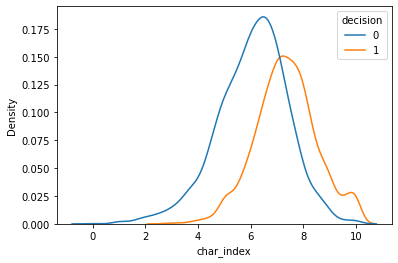

In [ ]:
temp_data1 = train_data[['attractive_important', 'sincere_important', 
                        'intelligence_important', 'funny_important', 
                        'ambition_important', 'shared_interests_important']].copy()
temp_data1 = temp_data1.div(temp_data1.sum(axis=1), axis=0)
temp_data1.columns = ['attractive_partner', 'sincere_partner', 
                      'intelligence_partner', 'funny_partner', 
                      'ambition_partner', 'shared_interests_partner']
temp_data2 = train_data[['attractive_partner', 'sincere_partner', 
                         'intelligence_partner', 'funny_partner', 
                         'ambition_partner', 'shared_interests_partner']].copy()
temp_data1['char_index'] = (temp_data1*temp_data2).sum(axis=1)
#temp_data1['char_index'] = temp_data1['char_index'] * train_data['gender']
temp_data1['decision'] = train_data['decision'].copy()
sns.kdeplot(x='char_index', data=temp_data1, hue='decision')
plt.show()

The plot above shows that there is a threshold for the index after which positive decisions dominate. After trying some thresholds, it turns out that 5 can be a good one.

In [ ]:
temp_data1[temp_data1['char_index']<5]['decision'].value_counts(normalize=True)

0    0.933504
1    0.066496
Name: decision, dtype: float64

Let's plot the index by gender.

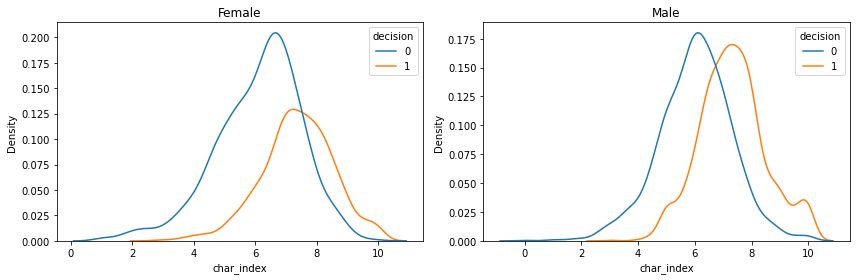

In [ ]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2 , 1)
sns.kdeplot(x='char_index', data=temp_data1[train_data['gender']==0], hue='decision')
plt.title('Female')
plt.subplot(1, 2 , 2)
sns.kdeplot(x='char_index', data=temp_data1[train_data['gender']==1], hue='decision')
plt.title('Male')
plt.tight_layout()

It seems that gender matter when the index is considered. Though 5 is still a good threshold both for males and females, which is shown below.

In [ ]:
temp_data1[(temp_data1['char_index']<5) & (train_data['gender']==0)]['decision'].value_counts(normalize=True)

0    0.931034
1    0.068966
Name: decision, dtype: float64

In [ ]:
temp_data1[(temp_data1['char_index']<5) & (train_data['gender']==1)]['decision'].value_counts(normalize=True)

0    0.936599
1    0.063401
Name: decision, dtype: float64

In [ ]:
# Now let's create clusters based on own interests (sport, clubbing, music, e.t.).

# from sklearn.cluster import KMeans

# temp_data = train_data[['sports', 'tvsports', 'exercise', 'dining',
#                          'museums', 'art', 'hiking', 'gaming',
#                          'clubbing', 'reading', 'tv', 'theater', 
#                          'movies', 'concerts', 'music', 'shopping', 
#                          'yoga']]

# inertia_list = []
# n_cluster_list = []
# for i in range(1, 21):
#   km_model = KMeans(n_clusters=3)
#   km_model.fit(temp_data)
#   n_cluster_list.append(i)
#   inertia_list.append(km_model.inertia_)

# plt.plot(n_cluster_list, inertia_list)
# plt.xlabel('n_cluster')
# plt.ylabel('inertia')
# plt.show()

In [ ]:
# temp_data['cluster'] = km_model.predict(temp_data)
# temp_data['cluster'] = temp_data['cluster'].astype("category")
# temp_data['decision'] = train_data['decision'].copy()

# sns.countplot(x="cluster", data=temp_data, hue='decision');

## Feature engineering <a name="Part3"></a>

Let's use the insights from the EDA section to generate new features.

In [ ]:
# def correct_text(text):
#   text = text.replace(' / ', ' ').replace('/', ' ').strip()
#   text = text.replace(' [', ' ').replace('[', ' ').strip()
#   text = text.replace('] ', ' ').replace(']', ' ').strip()
#   text = text.replace(' & ', ' ').replace('&', ' ').strip()
#   text = text.replace(' : ', ' ').replace(': ', ' ').replace(':', ' ').strip()
#   text = text.replace(' -- ', ' ').replace('--', ' ').strip()
#   text = text.replace(' . ', ' ').replace('. ', ' ').replace(' .', ' ').\
#          replace('.', '').strip()
#   text = text.replace(' - ', ' ').replace('-', ' ').strip()
#   text = text.replace(' ; ', ' ').replace('; ', ' ').replace(';', ' ').strip()
#   return text

In [ ]:
# temp_data = train_data['field'].map(label_dic['field']).apply(correct_text)
# temp_data.head()

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(stop_words={'english'})
# X_temp_data = vectorizer.fit_transform(temp_data)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# Sum_of_squared_distances = []
# K = range(2,10)
# for k in K:
#    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
#    km = km.fit(X_temp_data)
#    Sum_of_squared_distances.append(km.inertia_)
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()


Before proceeding let's create 2 new data frames to use in training and testing.

In [ ]:
X_train_new = pd.DataFrame()
X_test_new = pd.DataFrame()

Adding features from the main dataset.

In [ ]:
for col in ['like', 'attractive_partner', 'funny_partner', 'gender',
            'shared_interests_partner', 'field', 'guess_prob_liked']:
    X_train_new[col] = X_train[col].copy()
    X_test_new[col] = X_test[col].copy()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
X_train_new['is_train'] = 1
X_test_new['is_train'] = 0
X_data = pd.concat([X_train_new, X_test_new], axis=0).reset_index(drop=True)



In [ ]:
field_cat_len = len(X_data['field'].unique())
embedding_dim = [(field_cat_len, min(50, (field_cat_len + 1) // 2))]
embedding_dim

[(218, 50)]

In [ ]:
embed_representation=nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(218, 50)
)

In [ ]:
cat_feature = X_data['field']
cat_feature = torch.tensor(cat_feature,dtype=torch.int64)
cat_feature

tensor([ 0,  0,  0,  ..., 45, 45, 45])

In [ ]:
embedding_val=[]
for _,e in enumerate(embed_representation):
    embedding_val.append(e(cat_feature))

In [ ]:
z = torch.cat(embedding_val, 1)
z.cpu().detach().numpy()#.shape

array([[ 0.2037752 , -0.48608822,  0.83492285, ...,  2.5034587 ,
        -0.50024945, -0.27669185],
       [ 0.2037752 , -0.48608822,  0.83492285, ...,  2.5034587 ,
        -0.50024945, -0.27669185],
       [ 0.2037752 , -0.48608822,  0.83492285, ...,  2.5034587 ,
        -0.50024945, -0.27669185],
       ...,
       [-0.68863285,  1.2696031 ,  0.68835014, ...,  0.92240816,
         0.99736714,  1.3969799 ],
       [-0.68863285,  1.2696031 ,  0.68835014, ...,  0.92240816,
         0.99736714,  1.3969799 ],
       [-0.68863285,  1.2696031 ,  0.68835014, ...,  0.92240816,
         0.99736714,  1.3969799 ]], dtype=float32)

Using 13 as a threshold for expected_num_interested_in_me to construct a boolean variable.

In [ ]:
X_train_new['isg13_eniim'] = (X_train['expected_num_interested_in_me'] > 13).astype(int)
X_test_new['isg13_eniim'] = (X_test['expected_num_interested_in_me'] > 13).astype(int)

Creating a boolean variable indicating whether partners have met before or not.

In [ ]:
X_train_new['isg0_met'] = (X_train['met'] > 0).astype(int)
X_test_new['isg0_met'] = (X_test['met'] > 0).astype(int)

Creating a boolean variable which is 1 if race of self is European/Caucasian-American and 0 otherwise.

In [ ]:
X_train_new['is_race'] = (X_train['race'] == 'European/Caucasian-American').astype(int)
X_test_new['is_race'] = (X_test['race'] == 'European/Caucasian-American').astype(int)

Creating a boolean variable which is 1 if race of a partner is Asian/Pacific Islander/Asian-American and 0 otherwise.

In [ ]:
X_train_new['is_race_o'] = (X_train['race_o'] == 'Asian/Pacific Islander/Asian-American').astype(int)
X_test_new['is_race_o'] = (X_test['race_o'] == 'Asian/Pacific Islander/Asian-American').astype(int)

Constructing a feature that is 1 if the importance of same race is greater than 1.5 and 0 otherwise.

In [ ]:
X_train_new['isg1.5_isr'] = (X_train['importance_same_race'] > 1.5).astype(int)
X_test_new['isg1.5_isr'] = (X_test['importance_same_race'] > 1.5).astype(int)

Creating a boolean variable which is 1 if the importance of same religion is greater than 1 and 0 otherwise.

In [ ]:
X_train_new['isg1_isre'] = (X_train['importance_same_religion'] > 1).astype(int)
X_test_new['isg1_isre'] = (X_test['importance_same_religion'] > 1).astype(int)

Using 20 and 10 thresholds to construct boolean features out of variables related to importance of the characteristics.

In [ ]:
for col in ['attractive_important', 'sincere_important', 
            'intelligence_important', 'funny_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg20_{temp_col}'] = (X_train[col] > 20).astype(int)
    X_test_new[f'isg20_{temp_col}'] = (X_test[col] > 20).astype(int)

for col in ['ambition_important', 'shared_interests_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg10_{temp_col}'] = (X_train[col] > 10).astype(int)
    X_test_new[f'isg10_{temp_col}'] = (X_test[col] > 10).astype(int)

Using 8, 7, and 9 thresholds to construct boolean features out of variables related to the self characteristics (rated by self).

In [ ]:
for col in ['intelligence', 'funny', 'ambition']:
    X_train_new[f'isg8_{col}'] = (X_train[col] > 8).astype(int)
    X_test_new[f'isg8_{col}'] = (X_test[col] > 8).astype(int)

X_train_new['isg7_attractive'] = (X_train['attractive'] > 7).astype(int)
X_test_new['isg7_attractive'] = (X_test['attractive'] > 7).astype(int)

X_train_new['isg9_sincere'] = (X_train['sincere'] > 9).astype(int)
X_test_new['isg9_sincere'] = (X_test['sincere'] > 9).astype(int)

Using 8 and 7 thresholds to construct boolean features out of variables related to the characteristics of a partner (rated by self).

In [ ]:
for col in ['attractive_partner', 'sincere_partner', 
            'intelligence_partner', 'funny_partner']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg8_{temp_col}'] = (X_train[col] > 8).astype(int)
    X_test_new[f'isg8_{temp_col}'] = (X_test[col] > 8).astype(int)

for col in ['ambition_partner', 'shared_interests_partner']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg7_{temp_col}'] = (X_train[col] > 7).astype(int)
    X_test_new[f'isg7_{temp_col}'] = (X_test[col] > 7).astype(int)

Using 8, 1, 7.5, 6, and 10 thresholds to construct boolean features out of variables related to the self interests.

In [ ]:
for col in ['exercise', 'dining', 'museums', 'reading', 'movies']:
    X_train_new[f'isg8_{col}'] = (X_train[col] > 8).astype(int)
    X_test_new[f'isg8_{col}'] = (X_test[col] > 8).astype(int)

for col in ['tvsports', 'gaming', 'yoga']:
    X_train_new[f'isg1_{col}'] = (X_train[col] > 1).astype(int)
    X_test_new[f'isg1_{col}'] = (X_test[col] > 1).astype(int)

for col in ['art', 'hiking', 'clubbing', 'theater', 'concerts']:
    X_train_new[f'isg7.5_{col}'] = (X_train[col] > 7.5).astype(int)
    X_test_new[f'isg7.5_{col}'] = (X_test[col] > 7.5).astype(int)

for col in ['tv', 'shopping']:
    X_train_new[f'isg6_{col}'] = (X_train[col] > 6).astype(int)
    X_test_new[f'isg6_{col}'] = (X_test[col] > 6).astype(int)

X_train_new['isg10_music'] = (X_train['music'] > 10).astype(int)
X_test_new['isg10_music'] = (X_test['music'] > 10).astype(int)

Constructing a feature that is 1 if the intrests' correlation is greater than 0.4 and 0 otherwise.

In [ ]:
X_train_new['isg0.4_intcor'] = (X_train['interests_correlate'] > 0.4).astype(int)
X_test_new['isg0.4_intcor'] = (X_test['interests_correlate'] > 0.4).astype(int)

Creating a boolean variable which is 1 if expected_happy_with_sd_people is greater than 6 and 0 otherwise.

In [ ]:
X_train_new['isg6_ehwsp'] = (X_train['expected_happy_with_sd_people'] > 6).astype(int)
X_test_new['isg6_ehwsp'] = (X_test['expected_happy_with_sd_people'] > 6).astype(int)

Constructing a feature that is 1 if expected_num_matches is greater than 2.5 and 0 otherwise.

In [ ]:
X_train_new['isg2.5_enm'] = (X_train['expected_num_matches'] > 2.5).astype(int)
X_test_new['isg2.5_enm'] = (X_test['expected_num_matches'] > 2.5).astype(int)

Creating features out of like variable using 7 and 4 thresholds.

In [ ]:
X_train_new['isge7_like'] = (X_train['like'] >= 7).astype(int)
X_test_new['isge7_like'] = (X_test['like'] >= 7).astype(int)

X_train_new['isle4_like'] = (X_train['like'] <= 4).astype(int)
X_test_new['isle4_like'] = (X_test['like'] <= 4).astype(int)

Constructing a feature that is 1 if like and age are greater or equal to 6 and 40 respectively. Of course it's 0 otherwise.

In [ ]:
X_train_new['isge6_40_like_age'] = ((X_train['like'] >= 6) & (X_train['age'] >= 40)).astype(int)
X_test_new['isge6_40_like_age'] = ((X_test['like'] >= 6) & (X_test['age'] >= 40)).astype(int)

Creating a boolean variable which is 1 if guess_prob_liked is greater than 6 and 0 otherwise.

In [ ]:
X_train_new['isg6_gpl'] = (X_train['guess_prob_liked'] > 6).astype(int)
X_test_new['isg6_gpl'] = (X_test['guess_prob_liked'] > 6).astype(int)

Constructing a feature that is 1 if partner attractiveness and age are greater or equal to 6 and 40 respectively. Of course it's 0 otherwise.

In [ ]:
X_train_new['isge6_40_att_age'] = ((X_train['attractive_partner'] >= 6) & (X_train['age'] >= 40)).astype(int)
X_test_new['isge6_40_att_age'] = ((X_test['attractive_partner'] >= 6) & (X_test['age'] >= 40)).astype(int)

Creating a boolean variable which is 1 if attractiveness of a partner is less than 4 and 0 otherwise.

In [ ]:
X_train_new['isl4_att_par'] = (X_train['attractive_partner'] < 4).astype(int)
X_test_new['isl4_att_par'] = (X_test['attractive_partner'] < 4).astype(int)

Using different thresholds to create 2 features out of sincere and like variables' iteraction.

In [ ]:
X_train_new['isle4_ge8_sin_like'] = ((X_train['sincere'] <= 4) & (X_train['like'] >= 8)).astype(int)
X_test_new['isle4_ge8_sin_like'] = ((X_test['sincere'] <= 4) & (X_test['like'] >= 8)).astype(int)

X_train_new['isge6_le4_sin_like'] = ((X_train['sincere'] >= 6) & (X_train['like'] <= 4)).astype(int)
X_test_new['isge6_le4_sin_like'] = ((X_test['sincere'] >= 6) & (X_test['like'] <= 4)).astype(int)

Utilising a line with 1.1 slope and 4/1.1 intercept to create features out of funny variable's iteraction with attractive_partner and like variables.

In [ ]:
X_train_new['below_funny_att'] = (X_train['funny'] < (1.1*X_train['attractive_partner'] - 4)).astype(int)
X_test_new['below_funny_att'] = (X_test['funny'] < (1.1*X_test['attractive_partner'] - 4)).astype(int)

X_train_new['below_funny_like'] = (X_train['funny'] < (1.1*X_train['like'] - 4)).astype(int)
X_test_new['below_funny_like'] = (X_test['funny'] < (1.1*X_test['like'] - 4)).astype(int)

Using different thresholds to create 2 features out of a partner's intelligence and attractiveness iteraction.

In [ ]:
X_train_new['isg6_ge9_att_int_par'] = ((X_train['attractive_partner'] > 6) & 
                                       (X_train['intelligence_partner'] >= 9)).astype(int)
X_test_new['isg6_ge9_att_int_par'] = ((X_test['attractive_partner'] > 6) & 
                                       (X_test['intelligence_partner'] >= 9)).astype(int)

X_train_new['isl5_8_att_int_par'] = ((X_train['attractive_partner'] < 5) & 
                                       (X_train['intelligence_partner'] < 8)).astype(int)
X_test_new['isl5_8_att_int_par'] = ((X_test['attractive_partner'] < 5) & 
                                       (X_test['intelligence_partner'] < 8)).astype(int)

Utilising different thresholds to create 2 features out of a partner's humour (funny feature) and attractiveness iteraction.

In [ ]:
X_train_new['isg8_att_fun_par'] = ((X_train['attractive_partner'] > 8) & 
                                   (X_train['funny_partner'] > 8)).astype(int)
X_test_new['isg8_att_fun_par'] = ((X_test['attractive_partner'] > 8) & 
                                  (X_test['funny_partner'] > 8)).astype(int)

X_train_new['isl5_8_att_fun_par'] = ((X_train['attractive_partner'] < 5) & 
                                     (X_train['funny_partner'] < 8)).astype(int)
X_test_new['isl5_8_att_fun_par'] = ((X_test['attractive_partner'] < 5) & 
                                    (X_test['funny_partner'] < 8)).astype(int)

Using different thresholds to create 2 features out of interests shared with a partner and a partner's attractiveness iteraction.

In [ ]:
X_train_new['isg6_8_att_si_par'] = ((X_train['attractive_partner'] > 6) & 
                                    (X_train['shared_interests_partner'] > 8)).astype(int)
X_test_new['isg6_8_att_si_par'] = ((X_test['attractive_partner'] > 6) & 
                                   (X_test['shared_interests_partner'] > 8)).astype(int)

X_train_new['isl5_8_att_si_par'] = ((X_train['attractive_partner'] < 5) & 
                                    (X_train['shared_interests_partner'] < 8)).astype(int)
X_test_new['isl5_8_att_si_par'] = ((X_test['attractive_partner'] < 5) & 
                                   (X_test['shared_interests_partner'] < 8)).astype(int)

Utilising iteraction of a partner's attractiveness and like variable to create a feature.

In [ ]:
X_train_new['isl5_8_attpar_like'] = ((X_train['attractive_partner'] < 5) & 
                                     (X_train['like'] < 8)).astype(int)
X_test_new['isl5_8_attpar_like'] = ((X_test['attractive_partner'] < 5) & 
                                    (X_test['like'] < 8)).astype(int)

Using iteraction of a partner's attractiveness and guess_prob_liked variable to create a feature.

In [ ]:
X_train_new['isl5_8_attpar_gpl'] = ((X_train['attractive_partner'] < 5) & 
                                    (X_train['guess_prob_liked'] < 8)).astype(int)
X_test_new['isl5_8_attpar_gpl'] = ((X_test['attractive_partner'] < 5) & 
                                   (X_test['guess_prob_liked'] < 8)).astype(int)

Utilising iteraction of a partner's sincerity and like variable to create a feature.

In [ ]:
X_train_new['isg5_8_sinpar_like'] = ((X_train['sincere_partner'] > 5) & 
                                     (X_train['like'] > 8)).astype(int)
X_test_new['isg5_8_sinpar_like'] = ((X_test['sincere_partner'] > 5) & 
                                    (X_test['like'] > 8)).astype(int)

Using iteraction of a partner's intelligence and like variable to create a feature.

In [ ]:
X_train_new['isg5_8_intpar_like'] = ((X_train['intelligence_partner'] > 5) & 
                                     (X_train['like'] > 8)).astype(int)
X_test_new['isg5_8_intpar_like'] = ((X_test['intelligence_partner'] > 5) & 
                                    (X_test['like'] > 8)).astype(int)

Utilising iteraction of a partner's humor (funny_partner) and like variable to create a feature.

In [ ]:
X_train_new['isg5_8_funpar_like'] = ((X_train['funny_partner'] > 5) & 
                                     (X_train['like'] > 8)).astype(int)
X_test_new['isg5_8_funpar_like'] = ((X_test['funny_partner'] > 5) & 
                                    (X_test['like'] > 8)).astype(int)

Using iteraction of shared_interests_partner and like variables to create a feature.

In [ ]:
X_train_new['isg5_8_sipar_like'] = ((X_train['shared_interests_partner'] > 5) & 
                                    (X_train['like'] > 8)).astype(int)
X_test_new['isg5_8_sipar_like'] = ((X_test['shared_interests_partner'] > 5) & 
                                   (X_test['like'] > 8)).astype(int)

Utilising iteraction of guess_prob_liked and like variables to create a feature.

In [ ]:
X_train_new['isl6_8_like_gpl'] = ((X_train['like'] < 6) & 
                                  (X_train['guess_prob_liked'] < 8)).astype(int)
X_test_new['isl6_8_like_gpl'] = ((X_test['like'] < 6) & 
                                 (X_test['guess_prob_liked'] < 8)).astype(int)

Creating new features out of a partner's characteristics iteraction with gender variable using different thresholds.



In [ ]:
for col in ['attractive_partner', 'sincere_partner', 
            'intelligence_partner', 'funny_partner',
            'ambition_partner', 'shared_interests_partner']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg8_{temp_col}_female'] = ((X_train[col] > 8) & 
                                              (X_train['gender']==0)).astype(int)
    X_test_new[f'isg8_{temp_col}_female'] = ((X_test[col] > 8) & 
                                             (X_test['gender']==0)).astype(int)

In [ ]:
for col in ['attractive_partner', 'sincere_partner', 
            'intelligence_partner', 'funny_partner']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg8_{temp_col}_male'] = ((X_train[col] > 8) & 
                                              (X_train['gender']==1)).astype(int)
    X_test_new[f'isg8_{temp_col}_male'] = ((X_test[col] > 8) & 
                                             (X_test['gender']==1)).astype(int)

X_train_new['isge7_ambpar_male'] = ((X_train['ambition_partner'] >= 7) & 
                                    (X_train['gender']==1)).astype(int)
X_test_new['isge7_ambpar_male'] = ((X_test['ambition_partner'] >= 7) & 
                                   (X_test['gender']==1)).astype(int)

X_train_new['isg7_sipar_male'] = ((X_train['shared_interests_partner'] > 7) & 
                                  (X_train['gender']==1)).astype(int)
X_test_new['isg7_sipar_male'] = ((X_test['shared_interests_partner'] > 7) & 
                                 (X_test['gender']==1)).astype(int)

Constructing new features out of the characteristics's importance iteraction with gender variable using different thresholds.

In [ ]:
for col in ['sincere_important', 'intelligence_important', 'funny_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg20_{temp_col}_female'] = ((X_train[col] > 20) & 
                                               (X_train['gender']==0)).astype(int)
    X_test_new[f'isg20_{temp_col}_female'] = ((X_test[col] > 20) & 
                                              (X_test['gender']==0)).astype(int)

for col in ['attractive_important', 'ambition_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg15_{temp_col}_female'] = ((X_train[col] > 15) & 
                                               (X_train['gender']==0)).astype(int)
    X_test_new[f'isg15_{temp_col}_female'] = ((X_test[col] > 15) & 
                                              (X_test['gender']==0)).astype(int)

X_train_new['isg10_siimp_female'] = ((X_train['shared_interests_important'] > 10) & 
                                     (X_train['gender']==0)).astype(int)
X_test_new['isg10_siimp_female'] = ((X_test['shared_interests_important'] > 10) & 
                                    (X_test['gender']==0)).astype(int)

In [ ]:
for col in ['attractive_important', 'sincere_important', 
            'intelligence_important', 'funny_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg20_{temp_col}_male'] = ((X_train[col] > 20) & 
                                               (X_train['gender']==1)).astype(int)
    X_test_new[f'isg20_{temp_col}_male'] = ((X_test[col] > 20) & 
                                              (X_test['gender']==1)).astype(int)

for col in ['ambition_important', 'shared_interests_important']:
    temp_col = col.split('_')[0][:3] + col.split('_')[-1][:3]
    X_train_new[f'isg10_{temp_col}_male'] = ((X_train[col] > 10) & 
                                               (X_train['gender']==1)).astype(int)
    X_test_new[f'isg10_{temp_col}_male'] = ((X_test[col] > 10) & 
                                              (X_test['gender']==1)).astype(int)

Utilising a partner's intelligence and gender variable iteraction to create a feature.

In [ ]:
X_train_new['isle4_intpar_female'] = ((X_train['intelligence_partner'] <= 4) & 
                                      (X_train['gender']==0)).astype(int)
X_test_new['isle4_intpar_female'] = ((X_test['intelligence_partner'] <= 4) & 
                                     (X_test['gender']==0)).astype(int)

Using a partner's attractiveness and gender variable iteraction to create a feature.

In [ ]:
X_train_new['isle4_attpar_female'] = ((X_train['attractive_partner'] <= 4) & 
                                      (X_train['gender']==0)).astype(int)
X_test_new['isle4_attpar_female'] = ((X_test['attractive_partner'] <= 4) & 
                                     (X_test['gender']==0)).astype(int)

Creating a boolean feature using a line with 0.1 slope and -1.5/0.1 intercept for funny_partner and funny_important iteraction.

In [ ]:
X_train_new['below_funpar_funimp'] = (X_train['funny_partner'] < (0.1*X_train['funny_important'] + 1.5)).astype(int)
X_test_new['below_funpar_funimp'] = (X_test['funny_partner'] < (0.1*X_test['funny_important'] + 1.5)).astype(int)

Constructing a boolean feature using a line with -2.5 slope and -30/2.5 intercept for funny_partner and funny_important iteraction.

In [ ]:
X_train_new['below_funpar_funimp2'] = (X_train['funny_partner'] < 
                                       (-2.5*X_train['funny_important'] + 30)).astype(int)
X_test_new['below_funpar_funimp2'] = (X_test['funny_partner'] < 
                                      (-2.5*X_test['funny_important'] + 30)).astype(int)

Creating the charecteristics' index mentioned in EDA section.

In [ ]:
def create_char_index(df):
    temp_data1 = df[['attractive_important', 'sincere_important', 
                     'intelligence_important', 'funny_important', 
                     'ambition_important', 'shared_interests_important']].copy()
    temp_data1 = temp_data1.div(temp_data1.sum(axis=1), axis=0)
    temp_data1.columns = ['attractive_partner', 'sincere_partner', 
                          'intelligence_partner', 'funny_partner', 
                          'ambition_partner', 'shared_interests_partner']
    temp_data2 = df[['attractive_partner', 'sincere_partner', 
                     'intelligence_partner', 'funny_partner', 
                     'ambition_partner', 'shared_interests_partner']].copy()
    temp_data1['char_index'] = (temp_data1*temp_data2).sum(axis=1)
    return temp_data1['char_index']

In [ ]:
X_train_new['char_index'] = create_char_index(df=X_train)
X_test_new['char_index'] = create_char_index(df=X_test)

Contstructing a feature for the index and gender variable iteraction.

In [ ]:
X_train_new['char_index_gender'] = X_train_new['char_index'] * X_train_new['gender']
X_test_new['char_index_gender'] = X_test_new['char_index'] * X_test_new['gender']

Using 5 threshold to create a boolean variable out of the index.

In [ ]:
X_train_new['isl5_char_index'] = (X_train_new['char_index'] < 5).astype(int)
X_test_new['isl5_char_index'] = (X_test_new['char_index'] < 5).astype(int)

## Model estimation <a name="Part4"></a>

First of all let's specify a metric to gauge the results. As the target variable is not equally distributed, let's use ROC AUC score.
<br>Now let's create an estimation function.

In [ ]:
def estimate_model(model, X, y):
    '''Prints ROC AUC score and returns estimated model

      Params:
      model: class, model for estimation
      X: dataframe, features
      y: series, target

      Returns:
      model: estimated model
    '''
    model.fit(X, y)
    # y_pred = model.predict(X)
    # print(f'Accuracy is {np.round(100*accuracy_score(y, y_pred), 3)} %.')
    y_pprob = model.predict_proba(X)[:, 1]
    print(f'ROC AUC for training set is {np.round(100*roc_auc_score(y, y_pprob), 3)} %.')
    return model

Let's use random forest classifier to find out important features.

In [ ]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model = estimate_model(model=rfc_model, X=X_train_new, y=y_train)
y_test_pprob = rfc_model.predict_proba(X_test_new)[:, 1]
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_pprob), 3)} %.')

ROC AUC for training set is 100.0 %.
ROC AUC for test set is 86.242 %.


In [ ]:
# rfc_model = RandomForestClassifier(random_state=42)
# rfc_model.fit(X_train_new, y_train)
# y_train_pred = rfc_model.predict(X_train_new)
# print(f'Accuracy is {np.round(100*accuracy_score(y_train, y_train_pred), 3)} %.')
# y_train_pprob = rfc_model.predict_proba(X_train_new)[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_train, y_train_pprob), 3)} %.')

# y_test_pred = rfc_model.predict(X_test_new)
# print(f'Accuracy is {np.round(100*accuracy_score(y_test, y_test_pred), 3)} %.')
# y_test_pprob = rfc_model.predict_proba(X_test_new)[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_test, y_test_pprob), 3)} %.')

Obtaining the features' importance.

In [ ]:
rfc_importances = rfc_model.feature_importances_
rfc_importance_df = pd.Series(rfc_importances, 
                              index=X_train_new.columns).to_frame()
rfc_importance_df.columns = ['importance']
rfc_importance_df = rfc_importance_df.sort_values('importance', ascending=False)
rfc_importance_df

,importance
attractive_partner,0.076289
char_index,0.069280
like,0.054779
isge7_like,0.048961
shared_interests_partner,0.045204
...,...
isle4_ge8_sin_like,0.000117
below_funny_like,0.000035
isg10_music,0.000000
is_race_o,0.000000


In [ ]:
# feature_important_list = sorted([(X_train_new.columns[i], rfc_importances[i]) 
#                                  for i in range(len(rfc_importances))], 
#                                 key= lambda x: x[1], reverse=True)
# keys = [elem[0] for elem in feature_important_list[:20]]
# values = [elem[1] for elem in feature_important_list[:20]]

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
# # fig = plt.figure(figsize=(12, 3))
# data.plot(kind='barh')
# plt.show()

Plotting features that have importance score greater than 0.008 (other thresholds have been tried, but this one returns highest ROC AUC score for training and test sets).

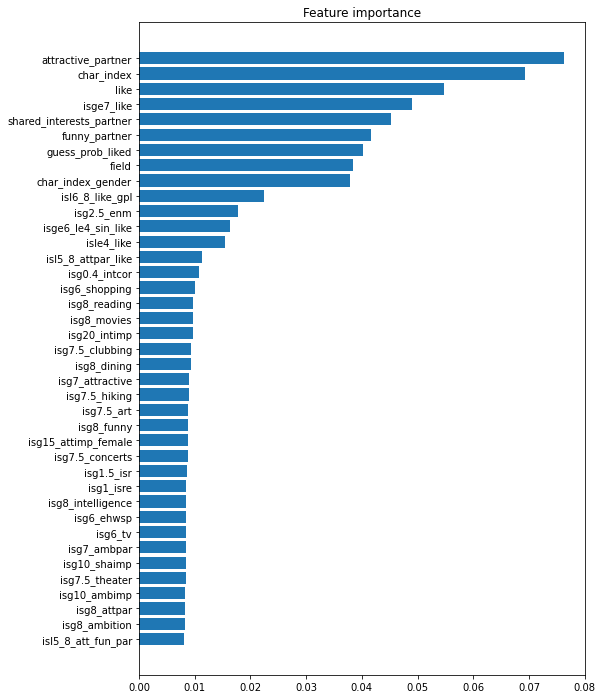

In [ ]:
scores = pd.Series(rfc_importances, index=X_train_new.columns)
scores = scores.sort_values(ascending=True)
scores = scores[scores > 0.008]
width = np.arange(len(scores))
ticks = list(scores.index)
fig = plt.figure(figsize=(8, 12))
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Feature importance")
plt.show()

In [ ]:
print(f"Total features' number is {X_train_new.shape[1]}.")
print(f"Reduced features' number is {len(ticks)}.")

Total features' number is 103.
Reduced features' number is 39.


Let's see the results with reduced number of features.

In [ ]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model = estimate_model(model=rfc_model, X=X_train_new[ticks], y=y_train)
y_train_rfc_pprob = rfc_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_rfc_pred = rfc_model.predict(X_train_new[ticks])
y_test_rfc_pprob = rfc_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_rfc_pred = rfc_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_rfc_pprob), 3)} %.')

ROC AUC for training set is 100.0 %.
ROC AUC for test set is 85.931 %.


In [ ]:
# rfc_model = RandomForestClassifier(random_state=42)
# rfc_model.fit(X_train_new[ticks], y_train)
# y_train_pred = rfc_model.predict(X_train_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_train, y_train_pred), 3)} %.')
# y_train_pprob = rfc_model.predict_proba(X_train_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_train, y_train_pprob), 3)} %.')

# y_test_pred = rfc_model.predict(X_test_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_test, y_test_pred), 3)} %.')
# y_test_pprob = rfc_model.predict_proba(X_test_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_test, y_test_pprob), 3)} %.')

Now let's create a function to conduct a cross validation.

In [ ]:
# def estimate_cv(model, X, y, cv=5, scoring='roc_auc'):
#     '''Prints ROC AUC scores for cross validation

#       Params:
#       model: class, model for estimation
#       X: dataframe, features
#       y: series, target
#       cv: int, number folds in cross validation
#       scoring: txt, model accuracy estimation metric
#     '''
#     cv_scores = cross_val_score(model, X, y, 
#                                 scoring=scoring, 
#                                 cv=cv)
#     print(f'Cross validation scores are {", ".join([str(np.round(100*i, 2))+\
#                                                     " %" for i in cv_scores])}.')
#     print(f'Average cross validation score is {np.round(100*np.mean(cv_scores), 2)} %.')

In [ ]:
def estimate_cv(model, X, y, n_splits=5):
    '''Prints ROC AUC scores for cross validation

      Params:
      model: class, model for estimation
      X: dataframe, features
      y: series, target
    '''
    cv_scores = []
    sgkf = StratifiedGroupKFold(n_splits=n_splits, random_state=42)
    for _, (dev_ind, val_ind) in enumerate(sgkf.split(X, y, groups=X['id'])):
        X_dev = X.iloc[dev_ind].drop('id', axis=1)
        y_dev = y.iloc[dev_ind]
        X_val = X.iloc[val_ind].drop('id', axis=1)
        y_val = y.iloc[val_ind]

        model.fit(X_dev, y_dev)
        temp_y_pprob = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, temp_y_pprob))
    print(f'Cross validation scores are {", ".join([str(np.round(100*i, 2))+\
                                                    " %" for i in cv_scores])}.')
    print(f'Average cross validation score is {np.round(100*np.mean(cv_scores), 2)} %.')

Getting cross validation scores for random forest.

In [ ]:
rfc_cv_model = RandomForestClassifier(random_state=42)
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=rfc_cv_model, X=X_cv, y=y_train)

Cross validation scores are 88.16 %, 88.74 %, 87.28 %, 87.18 %, 89.48 %.
Average cross validation score is 88.17 %.


In [ ]:
# rfc_model = RandomForestClassifier(random_state=42)
# cv_scores = cross_val_score(rfc_model, X_train_new[ticks], y_train, 
#                             scoring='roc_auc', cv=5)
# print(f'Cross validation scores are {", ".join([str(np.round(100*i, 2))+" %" for i in cv_scores])}.')
# print(f'Average cross validation score is {np.round(100*np.mean(cv_scores), 2)} %.')

Let's use logistic regression to obtain ROC AUC scores.

In [ ]:
lc_model = LogisticRegression()
lc_model = estimate_model(model=lc_model, X=X_train_new[ticks], y=y_train)
y_train_lc_pprob = lc_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_lc_pred = lc_model.predict(X_train_new[ticks])
y_test_lc_pprob = lc_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_lc_pred = lc_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_lc_pprob), 3)} %.')

lc_cv_model = LogisticRegression()
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=lc_cv_model, X=X_cv, y=y_train)

ROC AUC for training set is 85.681 %.
ROC AUC for test set is 85.068 %.
Cross validation scores are 85.31 %, 85.26 %, 84.08 %, 82.93 %, 85.96 %.
Average cross validation score is 84.71 %.


In [ ]:
# lc_model = LogisticRegression()
# lc_model.fit(X_train_new[ticks], y_train)
# y_train_pred = lc_model.predict(X_train_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_train, y_train_pred), 3)} %.')
# y_train_pprob = lc_model.predict_proba(X_train_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_train, y_train_pprob), 3)} %.')

# y_test_pred = lc_model.predict(X_test_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_test, y_test_pred), 3)} %.')
# y_test_pprob = lc_model.predict_proba(X_test_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_test, y_test_pprob), 3)} %.')

# lc_model = LogisticRegression()
# cv_scores = cross_val_score(lc_model, X_train_new[ticks], y_train, 
#                             scoring='roc_auc', cv=5)
# print(f'Cross validation scores are {", ".join([str(np.round(100*i, 2))+" %" for i in cv_scores])}.')
# print(f'Average cross validation score is {np.round(100*np.mean(cv_scores), 2)} %.')

Now let's use xgb classifier.

In [ ]:
xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model = estimate_model(model=xgb_model, X=X_train_new[ticks], y=y_train)
y_train_xgb_pprob = xgb_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_xgb_pred = xgb_model.predict(X_train_new[ticks])
y_test_xgb_pprob = xgb_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_xgb_pred = xgb_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_xgb_pprob), 3)} %.')

xgb_cv_model = xgb.XGBClassifier(n_jobs=-1)
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=xgb_cv_model, X=X_cv, y=y_train)

ROC AUC for training set is 90.619 %.
ROC AUC for test set is 85.718 %.
Cross validation scores are 87.61 %, 86.6 %, 86.75 %, 85.25 %, 88.55 %.
Average cross validation score is 86.95 %.


Now let's use Naive Bayes classifier.

In [ ]:
gnb_model = GaussianNB()
gnb_model = estimate_model(model=gnb_model, X=X_train_new[ticks], y=y_train)
y_train_gnb_pprob = gnb_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_gnb_pred = gnb_model.predict(X_train_new[ticks])
y_test_gnb_pprob = gnb_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_gnb_pred = gnb_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_gnb_pprob), 3)} %.')

gnb_cv_model = GaussianNB()
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=gnb_cv_model, X=X_cv, y=y_train)

ROC AUC for training set is 83.333 %.
ROC AUC for test set is 84.047 %.
Cross validation scores are 84.25 %, 83.87 %, 82.72 %, 81.16 %, 83.94 %.
Average cross validation score is 83.19 %.


Finally let's use KNeighborsClassifier.

In [ ]:
knc_model = KNeighborsClassifier()
knc_model = estimate_model(model=knc_model, X=X_train_new[ticks], y=y_train)
y_train_knc_pprob = knc_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_knc_pred = knc_model.predict(X_train_new[ticks])
y_test_knc_pprob = knc_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_knc_pred = knc_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_knc_pprob), 3)} %.')

knc_cv_model = KNeighborsClassifier()
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=knc_cv_model, X=X_cv, y=y_train)

ROC AUC for training set is 95.579 %.
ROC AUC for test set is 76.962 %.
Cross validation scores are 84.9 %, 83.28 %, 79.06 %, 82.82 %, 84.41 %.
Average cross validation score is 82.89 %.


In [ ]:
# xgb_model = xgb.XGBClassifier(n_jobs=-1)
# xgb_model.fit(X_train_new[ticks], y_train)
# y_train_pred = xgb_model.predict(X_train_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_train, y_train_pred), 3)} %.')
# y_train_pprob = xgb_model.predict_proba(X_train_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_train, y_train_pprob), 3)} %.')

# y_test_pred = xgb_model.predict(X_test_new[ticks])
# print(f'Accuracy is {np.round(100*accuracy_score(y_test, y_test_pred), 3)} %.')
# y_test_pprob = xgb_model.predict_proba(X_test_new[ticks])[:, 1]
# print(f'ROC AUC is {np.round(100*roc_auc_score(y_test, y_test_pprob), 3)} %.')

# xgb_model = xgb.XGBClassifier(n_jobs=-1)
# cv_scores = cross_val_score(xgb_model, X_train_new[ticks], y_train, 
#                             scoring='roc_auc', cv=5)
# print(f'Cross validation scores are {", ".join([str(np.round(100*i, 2))+" %" for i in cv_scores])}.')
# print(f'Average cross validation score is {np.round(100*np.mean(cv_scores), 2)} %.')

Let's use ensembling and stacking methods next. For this purposes we need to create matrices with predictions or probabilities from the models considered above.

In [ ]:
y_train_pprob = np.hstack([y_train_rfc_pprob.reshape(-1, 1), 
                           y_train_lc_pprob.reshape(-1, 1), 
                           y_train_xgb_pprob.reshape(-1, 1),
                           y_train_gnb_pprob.reshape(-1, 1),
                           y_train_knc_pprob.reshape(-1, 1)])
y_train_pred = np.hstack([y_train_rfc_pred.reshape(-1, 1), 
                          y_train_lc_pred.reshape(-1, 1), 
                          y_train_xgb_pred.reshape(-1, 1),
                          y_train_gnb_pred.reshape(-1, 1),
                          y_train_knc_pred.reshape(-1, 1)])

y_test_pprob = np.hstack([y_test_rfc_pprob.reshape(-1, 1), 
                          y_test_lc_pprob.reshape(-1, 1), 
                          y_test_xgb_pprob.reshape(-1, 1),
                          y_test_gnb_pprob.reshape(-1, 1),
                          y_test_knc_pprob.reshape(-1, 1)])
y_test_pred = np.hstack([y_test_rfc_pred.reshape(-1, 1), 
                         y_test_lc_pred.reshape(-1, 1), 
                         y_test_xgb_pred.reshape(-1, 1),
                         y_test_gnb_pred.reshape(-1, 1),
                         y_test_knc_pred.reshape(-1, 1)])

Creating a function to use ensembling by averaging probabilities.

In [ ]:
def mean_probs(x):
  '''Returns mean of all probabilities predicted by different models
     
     Args:
     x: n by m array of probabilities, where n is the number of samples 
        and m is the number of models used

     Output:
     n by 1 array of mean probabilities
  '''
  return x.mean(axis=1)

The ensembling results are as follows.

In [ ]:
print(f'ROC AUC for train set is {np.round(100*roc_auc_score(y_train, mean_probs(x=y_train_pprob)), 3)} %.')
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, mean_probs(x=y_test_pprob)), 3)} %.')

ROC AUC for train set is 96.342 %.
ROC AUC for test set is 85.727 %.


Let's try rank mean ensembling.

In [ ]:
def rank_mean(x):
  '''Returns mean rank for probabilities from different models
     
     Args:
     x: n by m array of probabilities, where n is the number of samples 
        and m is the number of models used

     Output:
     n by 1 array of mean ranks
  '''
  ranked = []
  for i in range(x.shape[1]):
    rank_data = stats.rankdata(x[:, i])
    ranked.append(rank_data)
  ranked = np.column_stack(ranked)
  return np.mean(ranked, axis=1)

The rank mean ensembling results are presented below.

In [ ]:
print(f'ROC AUC for train set is {np.round(100*roc_auc_score(y_train, rank_mean(x=y_train_pprob)), 3)} %.')
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, rank_mean(x=y_test_pprob)), 3)} %.')

ROC AUC for train set is 94.4 %.
ROC AUC for test set is 85.985 %.


Let's use oob score to choose n_estimators for random forest classifier.

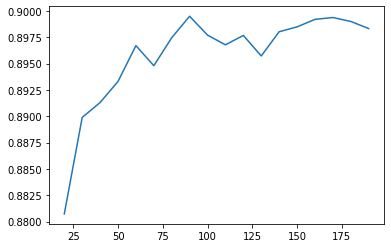

In [ ]:
def rf_clf(X, y, n_estimators=40, max_features=0.5, 
           min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
                                  max_features=max_features, 
                                  min_samples_leaf=min_samples_leaf, 
                                  oob_score=True).fit(X, y)


oob_error_list = []
n_estimators_list = []
for i in range(20, 200, 10):
  model = rf_clf(X=X_train_new[ticks], y=y_train, n_estimators=i)
  oob_pprob = model.oob_decision_function_[:, 1]
  oob_error_list.append(roc_auc_score(y_train, oob_pprob))
  n_estimators_list.append(i)

plt.plot(n_estimators_list, oob_error_list)
plt.show()

Judging by the chart above we can set n_estimators to 180. Moreover let's set max_features to 0.5 and min_samples_leaf to 5.

In [ ]:
rfc_tuned_model = RandomForestClassifier(random_state=42, n_estimators=180, 
                                         max_features=0.5, min_samples_leaf=5)
rfc_tuned_model = estimate_model(model=rfc_tuned_model, 
                                 X=X_train_new[ticks], y=y_train)
y_train_rfc_pprob = rfc_tuned_model.predict_proba(X_train_new[ticks])[:, 1]
y_train_rfc_pred = rfc_tuned_model.predict(X_train_new[ticks])
y_test_rfc_pprob = rfc_tuned_model.predict_proba(X_test_new[ticks])[:, 1]
y_test_rfc_pred = rfc_tuned_model.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, y_test_rfc_pprob), 3)} %.')

rfc_tuned_cv_model = RandomForestClassifier(random_state=42, n_estimators=180, 
                                            max_features=0.5, 
                                            min_samples_leaf=5)
X_cv = X_train_new[ticks].copy()
X_cv['id'] = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
estimate_cv(model=rfc_tuned_cv_model, X=X_cv, y=y_train)

ROC AUC for training set is 98.381 %.
ROC AUC for test set is 86.07 %.
Cross validation scores are 87.63 %, 87.46 %, 87.05 %, 86.03 %, 89.09 %.
Average cross validation score is 87.45 %.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'eta': [0.01, 0.015, 0.025, 0.05, 0.1],
              'gamma': [0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
              'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
              'min_child_weight': [1, 3, 5, 7],
              'subsample': [0.6, 0.7, 0.8, 0.9, 1],
              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
              #'lambda': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 1],
              'alpha': [0, 0.1, 0.5, 1]}

xgb_rscv_model = xgb.XGBClassifier(n_jobs=-1)

#f1_macro = make_scorer(f1_score , average='macro')

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42)
group_index = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
cv_fold_list = list(sgkf.split(X_train_new[ticks], y_train, groups=group_index))
rfc_rscv_model = RandomForestClassifier()
xgb_rscv = RandomizedSearchCV(estimator = xgb_rscv_model, 
                              param_distributions = param_grid, 
                              n_iter = 100, cv = cv_fold_list, verbose=2, 
                              random_state=42, n_jobs = -1)
xgb_rscv.fit(X_train_new[ticks], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.6min


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 6455, 6456, 6457]),
                        array([  10,   11,   12, ..., 6345, 6346, 6347])),
                       (array([  10,   11,   12, ..., 6455, 6456, 6457]),
                        array([   0,    1,    2, ..., 6389, 6390, 6391])),
                       (array([   0,    1,    2, ..., 6455, 6456, 6457]),
                        array([  20,   21,   22, ..., 6411, 6412, 6413])),
                       (array([   0,    1,    2, ..., 6433, 6434, 6435]),
                        array([  30,   31,   32, ..., 6455, 6456, 6457])),
                       (array([   0,    1,    2, ..., 6455, 6456, 6457]),...
                   param_distributions={'alpha': [0, 0.1, 0.5, 1],
                                        'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1],
                                        'eta': [0.01, 0.015, 0.025, 0.05, 0.1],
                                  

In [ ]:
xgb_rscv_train_pred = xgb_rscv.predict(X_train_new[ticks])
print(f'ROC AUC for train set is {np.round(100*roc_auc_score(y_train, xgb_rscv_train_pred), 3)} %.')

xgb_rscv_test_pred = xgb_rscv.predict(X_test_new[ticks])
print(f'ROC AUC for test set is {np.round(100*roc_auc_score(y_test, xgb_rscv_test_pred), 3)} %.')

ROC AUC for train set is 81.195 %.
ROC AUC for test set is 77.446 %.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42)
group_index = data.iloc[index_fold_dic[random_fold][0]]['id'].copy()
cv_fold_list = list(sgkf.split(X_train_new[ticks], y_train, groups=group_index))
rfc_rscv_model = RandomForestClassifier()
rfc_rscv = RandomizedSearchCV(estimator = rfc_rscv_model, 
                              param_distributions = random_grid, 
                              n_iter = 100, cv = cv_fold_list, verbose=2, 
                              random_state=42, n_jobs = -1)
rfc_rscv.fit(X_train_new[ticks], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 52.9min finished


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 6455, 6456, 6457]),
                        array([  10,   11,   12, ..., 6345, 6346, 6347])),
                       (array([  10,   11,   12, ..., 6455, 6456, 6457]),
                        array([   0,    1,    2, ..., 6389, 6390, 6391])),
                       (array([   0,    1,    2, ..., 6455, 6456, 6457]),
                        array([  20,   21,   22, ..., 6411, 6412, 6413])),
                       (array([   0,    1,    2, ..., 6433, 6434, 6435]),
                        array([  30,   31,   32, ..., 6455, 6456, 6457])),
                       (array([   0,    1,    2, ..., 6455, 6456, 6457]),...
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max

In [ ]:
rfc_rscv_train_pred = rfc_rscv.predict(X_train_new[ticks])
roc_auc_score(y_train, rfc_rscv_train_pred)

0.9766508681628973

In [ ]:
rfc_rscv_test_pred = rfc_rscv.predict(X_test_new[ticks])
roc_auc_score(y_test, rfc_rscv_test_pred)

0.7793730584044593

The following table summarises the results.

Model|ROC AUC train (%)|ROC AUC test (%)|average ROC AUC cv (%)|
-----|-------------|----------|------------|
RandomForest|100| 85.93| 88.17|
LogisticRegression|85.68| 85.07| 84.71|
XGBClassifier|90.62| 85.72| 86.95|
GaussianNB|83.33| 84.05| 83.19|
KNeighboursClassifier|95.58| 76.96| 82.89|
Ensembling (equal weights)|96.34| 85.73||
Ensembling (rank mean)|94.4| 85.99||
Tuned RandomForest|98.38| 86.07| 87.45|

Based on the table above, random forest or its tuned version can be chosen to predict the decision outcome. As non tuned version overfits on training set, let's choose the tuned one.

In [ ]:
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code

In [ ]:
best_parameters = model.best_estimator_.get_params()
for param in sorted(param_grid.keys()):
    print('{}: {}'.format(param, best_parameters[param]))

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);